In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
! pip install geopandas
import geopandas as gpd
import numpy as np
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
! pip install hydrofunctions
import hydrofunctions as hf
import pickle
import matplotlib.font_manager as fm
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
matplotlib.rc('font', family='TH Sarabun New')
plt.rcParams.update({'font.size': 12})

     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 6.3 MB 35.9 MB/s 
     |████████████████████████████████| 16.7 MB 341 kB/s 
     |████████████████████████████████| 220 kB 4.5 MB/s 
--2022-03-15 22:27:48--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2022-03-15 22:27:48--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


## Import information about study sites

In [ ]:
# import shapefile of study site locations and metadata
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/california_site_list.zip'
gages = gpd.read_file(loc).to_crs(epsg = 4326)
# import basin outlines
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/california_site_watershed_boundaries.zip'
basin_outlines = gpd.read_file(loc).to_crs(epsg = 4326)
gage_info = gages.merge(basin_outlines,left_on='SITE_NO',
            right_on='SITE_NO')
# US state map from https://catalog.data.gov/dataset/tiger-line-shapefile-2017-nation-u-s-current-state-and-equivalent-national
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/state_outline.zip'
state_outline = gpd.read_file(loc).to_crs(epsg = 4326)
state_outline = state_outline[state_outline.STUSPS=='CA']

## Import analysis results about SWE, deficits, ET, and streamflow

In [ ]:

# bring in WY totals from deficit and ET calculations
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/WY_data_allsites.csv'
aggregate_wy_data = pd.read_csv(loc).set_index('wy')

base_loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/site_data_wy_totals/all_deficit_data_'
wy_totals = {}
for sitenum in gages.SITE_NO.values:
  wy_totals[sitenum] = pd.read_csv(base_loc+str(sitenum)+'.csv').set_index('wy')

# combine with April 1 SWE and spring/january streamflow and residuals
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/april_swe_study_sites_mm.csv'
aprilSWE = pd.read_csv(loc).set_index('wy')
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/spring_streamflow_mm.csv'
springflow = pd.read_csv(loc).set_index('wy')
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/swe_q_residuals_mm.csv'
residuals = pd.read_csv(loc).set_index('wy')
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/january_mean_flow_mm_day.csv'
for sitenum in gages.SITE_NO.values:
  wy_totals[sitenum] = wy_totals[sitenum].merge(aprilSWE[[sitenum]].rename(columns={sitenum:'aprSWE'}),
                                                left_index=True,right_index=True)
  wy_totals[sitenum] = wy_totals[sitenum].merge(springflow[[sitenum]].rename(columns={sitenum:'springQ'}),
                                                left_index=True,right_index=True)
  wy_totals[sitenum] = wy_totals[sitenum].merge(residuals[[sitenum]].rename(columns={sitenum:'residuals'}),
                                                left_index=True,right_index=True)


meanAprSWE = aprilSWE.mean(axis=1).to_frame().rename(columns={0:'aprSWE'})
meanSpringQ = springflow.mean(axis=1).to_frame().rename(columns={0:'springQ'})
res_all = residuals.drop(columns='all_sites').sum(axis=1).to_frame().rename(columns={0:'residuals'})
aggregate_wy_data = aggregate_wy_data.merge(meanAprSWE,left_index=True,right_index=True)
aggregate_wy_data = aggregate_wy_data.merge(meanSpringQ,left_index=True,right_index=True)
aggregate_wy_data = aggregate_wy_data.merge(res_all,left_index=True,right_index=True)

padj_all = ''
for key in wy_totals:
  if len(padj_all)==0:
    padj_all = wy_totals[key][['adjP']].rename(columns={'adjP':key})
  else:
    padj_all = padj_all.merge(wy_totals[key][['adjP']].rename(columns={'adjP':key}),
                              left_index=True,right_index=True)
aggregate_wy_data['adjP'] = padj_all.mean(axis=1)


# bring in melt rates
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/melt_rates.csv'
meltrates = pd.read_csv(loc).set_index('wy')
aggregate_wy_data = aggregate_wy_data.merge(meltrates.mean(axis=1).to_frame().rename(columns={0:'melt_rate'}),
                                            left_index=True, right_index=True)
for sitenum in gages.SITE_NO.values:
  wy_totals[sitenum] = wy_totals[sitenum].merge(meltrates[[sitenum]].rename(columns={sitenum:'melt_rate'}),
                                                left_index=True, right_index=True)
  
# bring in spring streamflow
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/spring_streamflow_mm.csv'
springflow = pd.read_csv(loc).set_index('wy')
aggregate_wy_data = aggregate_wy_data.merge(springflow.mean(axis=1).to_frame().rename(columns={0:'springflow'}),
                                            left_index=True, right_index=True)
for sitenum in gages.SITE_NO.values:
  wy_totals[sitenum] = wy_totals[sitenum].merge(springflow[[sitenum]].rename(columns={sitenum:'springflow'}),
                                                left_index=True, right_index=True)


In [ ]:
wy_totals[sitenum]

wy.1            P        adjP  ...  residuals  melt_rate  springflow
wy                                   ...                                  
2004  2004   456.457784  277.697784  ...  31.716881   7.960727  107.052119
2005  2005  1148.281452  744.335997  ...  25.106465  11.603762  192.618648
2006  2006   929.094821  518.931915  ...  66.516826  13.064918  241.204993
2007  2007   417.700753  233.588026  ...  10.450008   6.993840   99.795640
2008  2008   627.635751  160.505194  ... -49.536040  14.970377  103.890386
2009  2009   719.876303  497.943126  ...  -5.547969   8.810967  119.427031
2010  2010   782.321696  372.287496  ... -23.341216  11.742555  149.004870
2011  2011  1131.837697  463.974522  ... -34.147513  16.271204  205.621701
2012  2012   397.725219  270.194310  ...   1.583483   9.307797   99.660287
2013  2013   462.379746  186.890724  ... -24.949181   9.441758   88.238101
2014  2014   365.718926  308.364580  ... -15.179707  10.197391   72.744822
2015  2015   346.897712  307.283251  ...  -8.573342   8.354003   61.911353
2016  2016   716.882084  454.118448  ... -30.664366   8.883053  100.415897
2017  2017  1549.349752  824.858843  ...  92.706475  18.542091  283.465244
2018  2018   605.966949  443.732695  ...  27.152312   9.808048  129.448383
2019  2019  1020.976385  404.030930  ... -33.329221  13.226428  190.485858
2020  2020   421.706938  268.360795  ...  -3.011521   6.849152   93.248777
2021  2021   429.452148  262.470330  ... -26.952376   7.224179   75.367115

[18 rows x 20 columns]

## Use a random forest to explore relative importance of proposed mechanisms

In [ ]:
import joblib
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import r2_score

R2 = 0.95


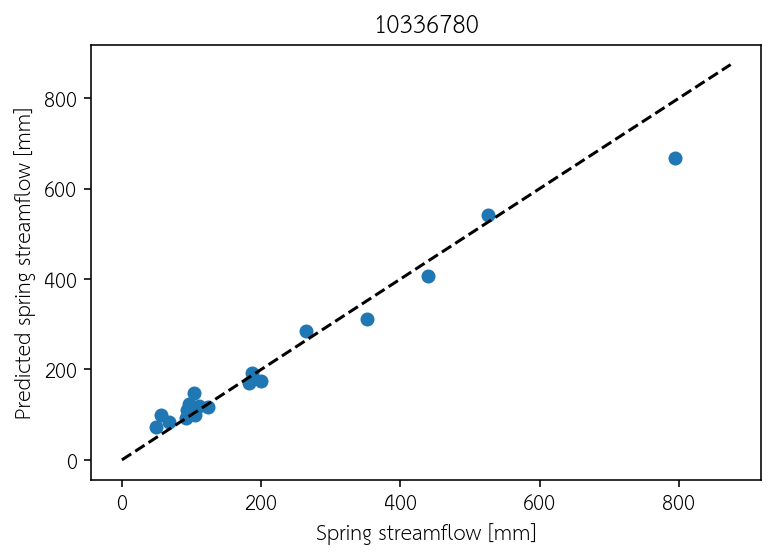

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


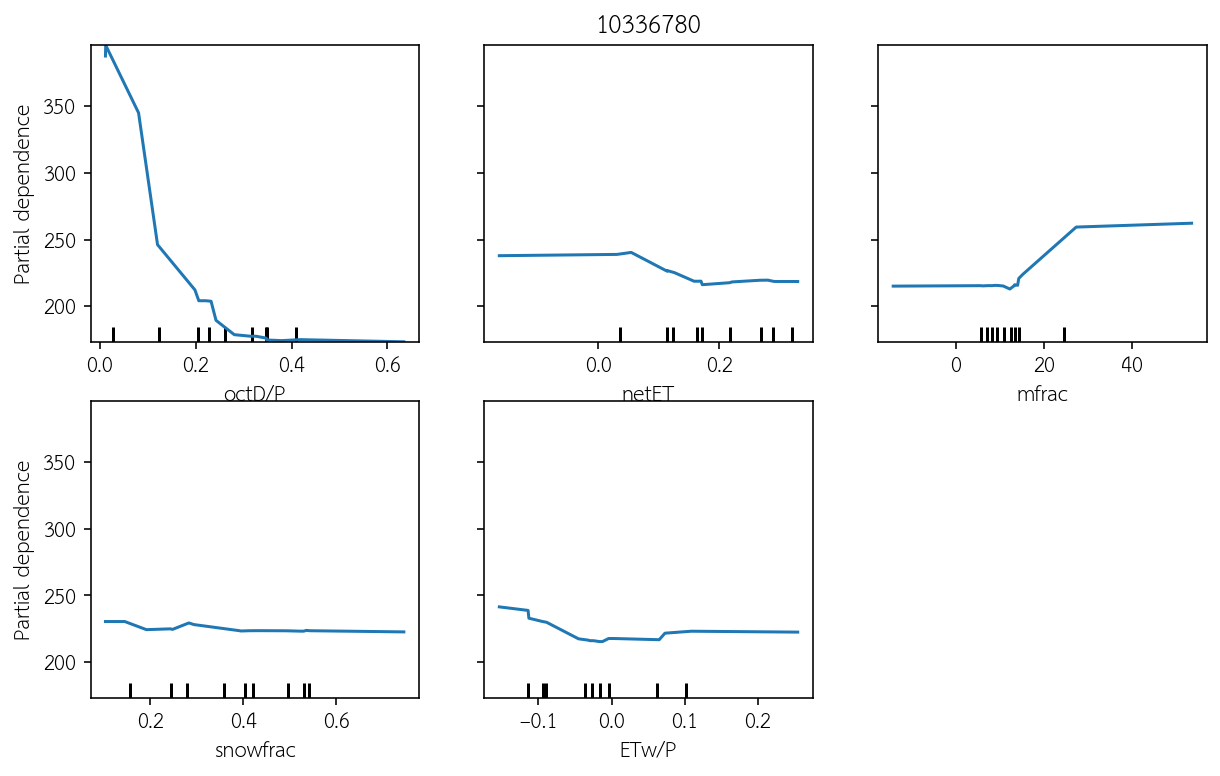


R2 = 0.94


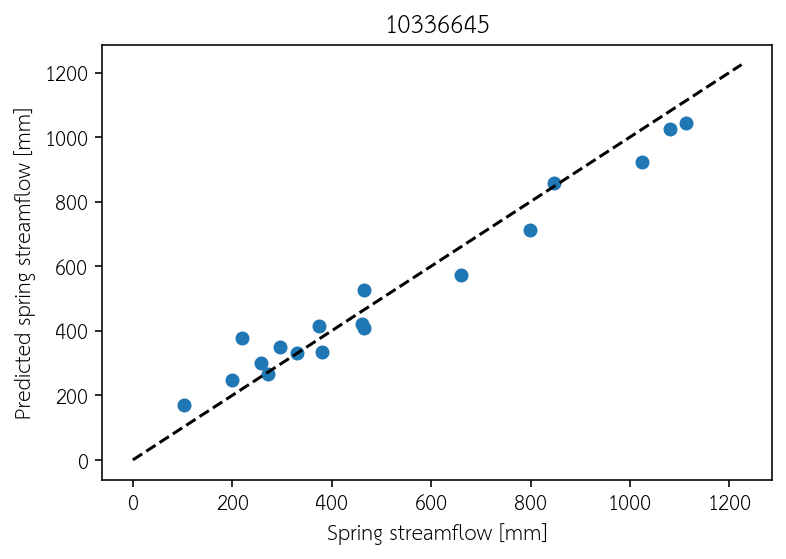

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


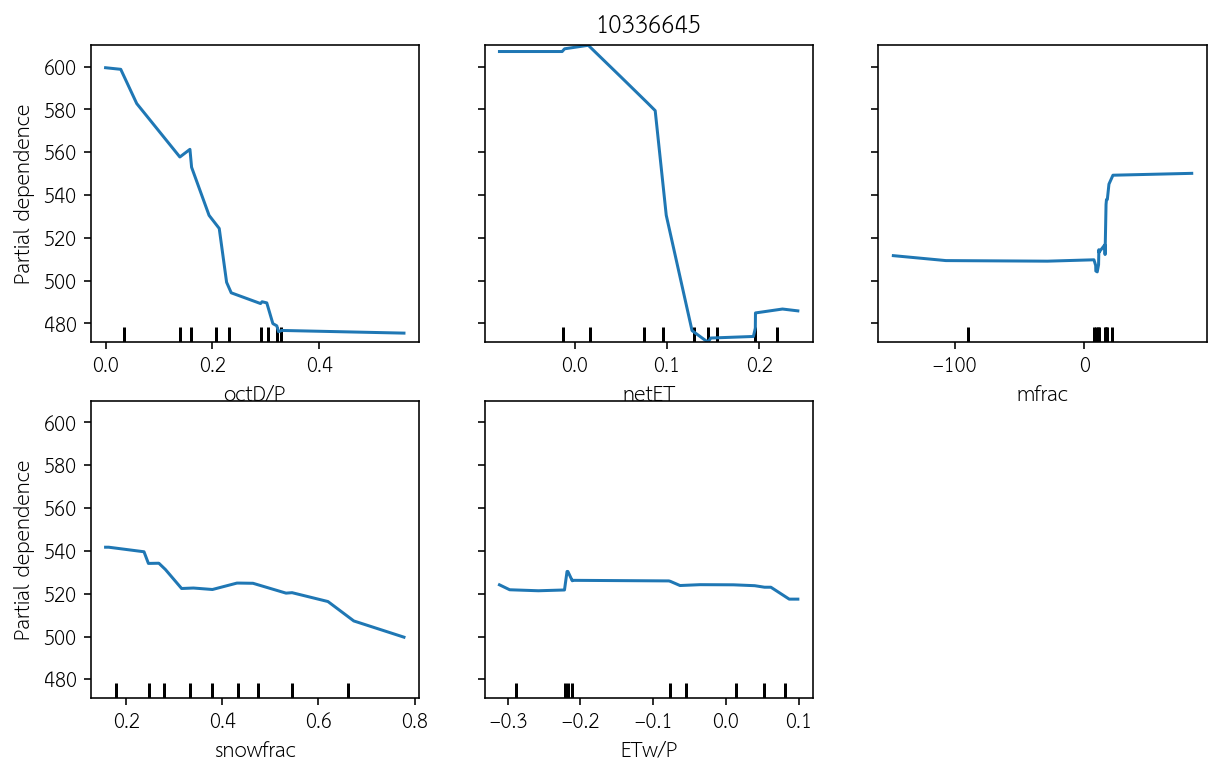


R2 = 0.96


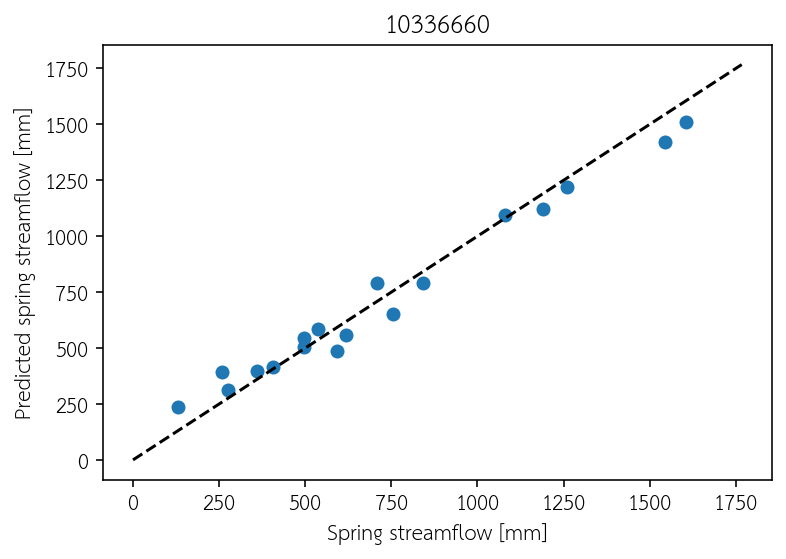

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


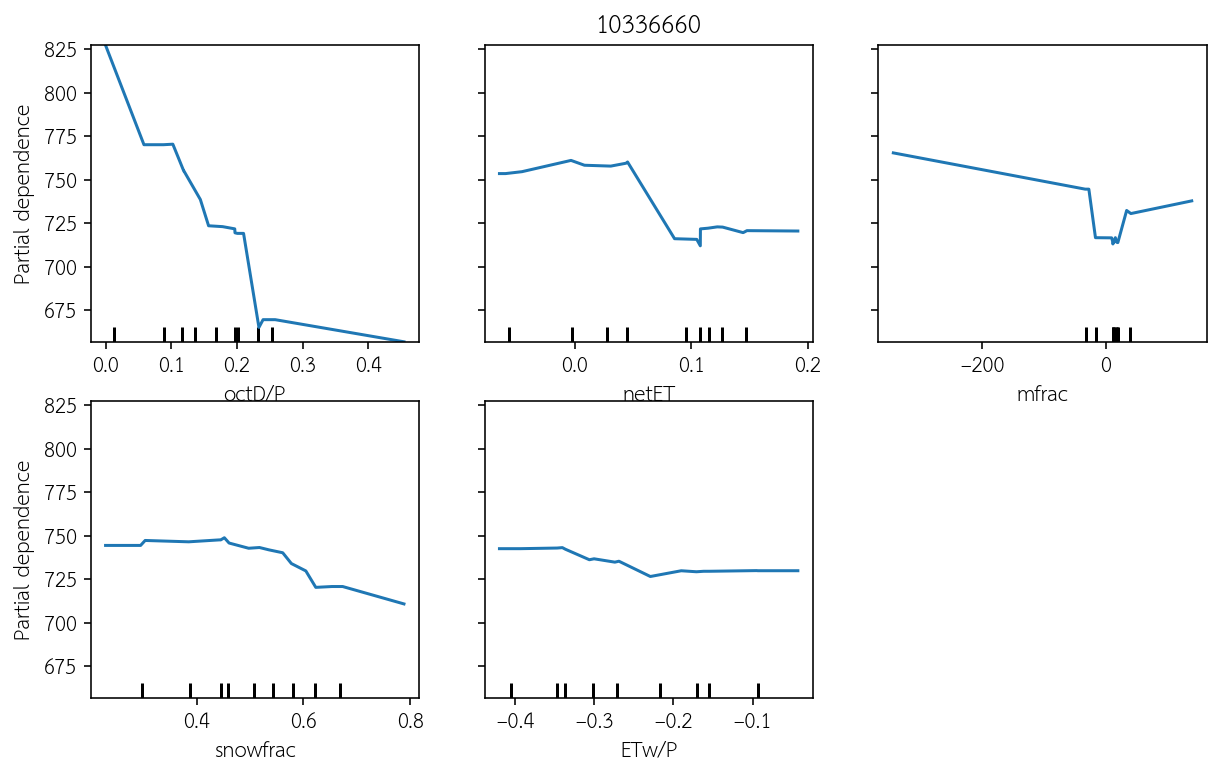


R2 = 0.97


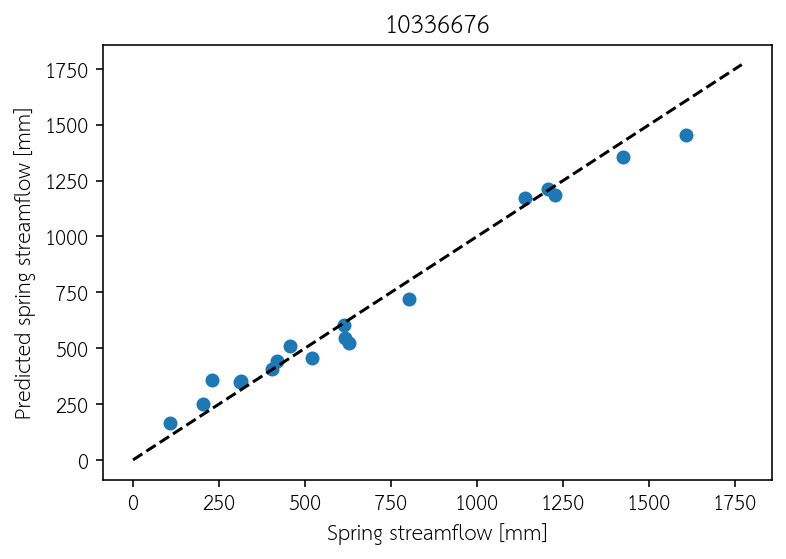

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


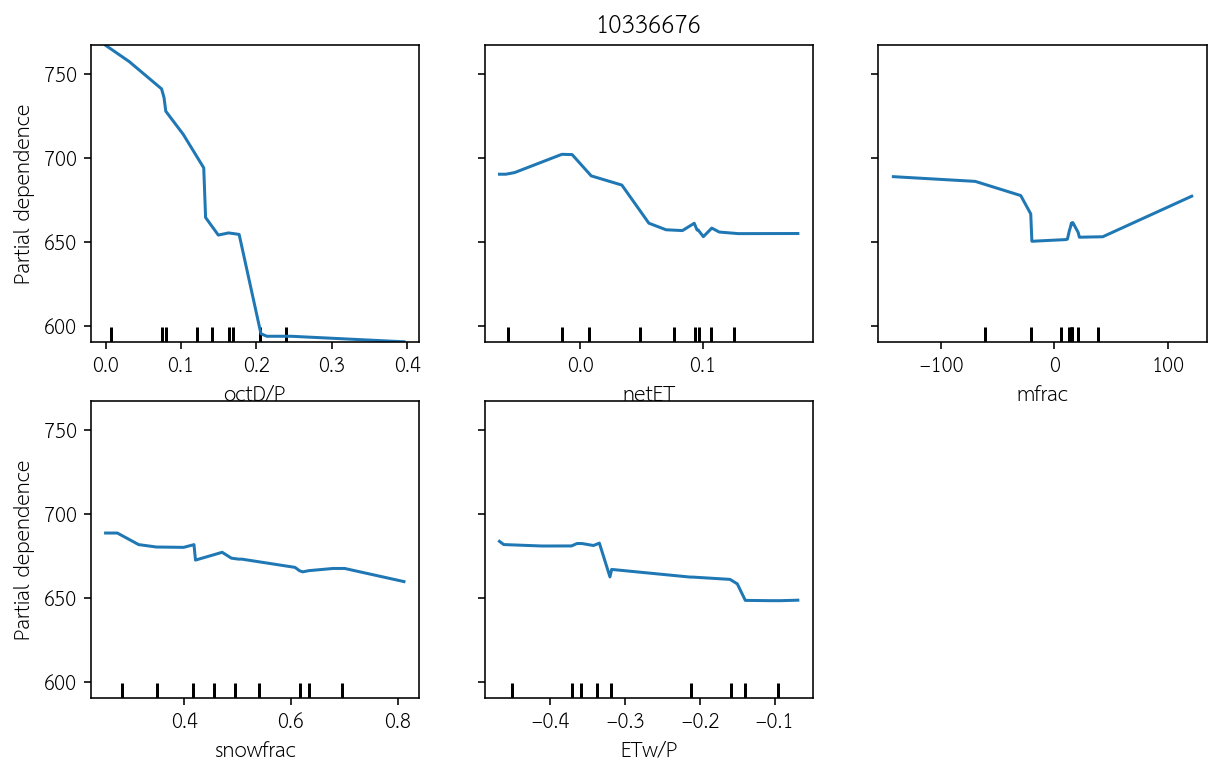


R2 = 0.91


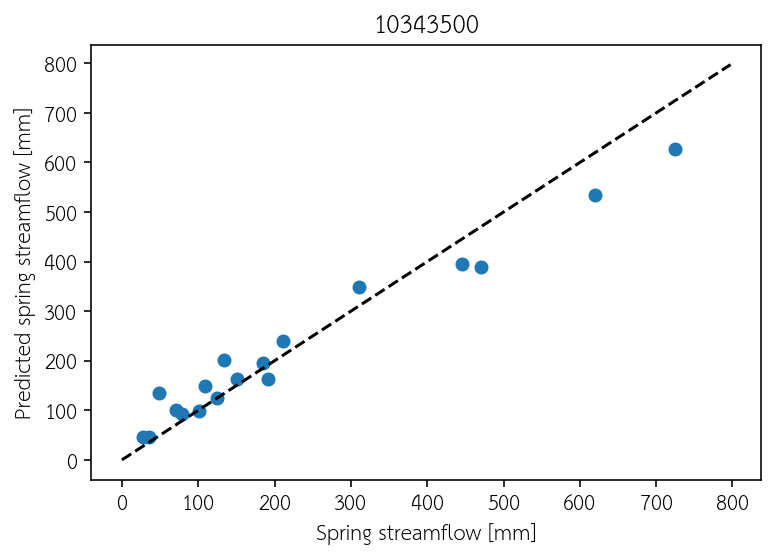

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


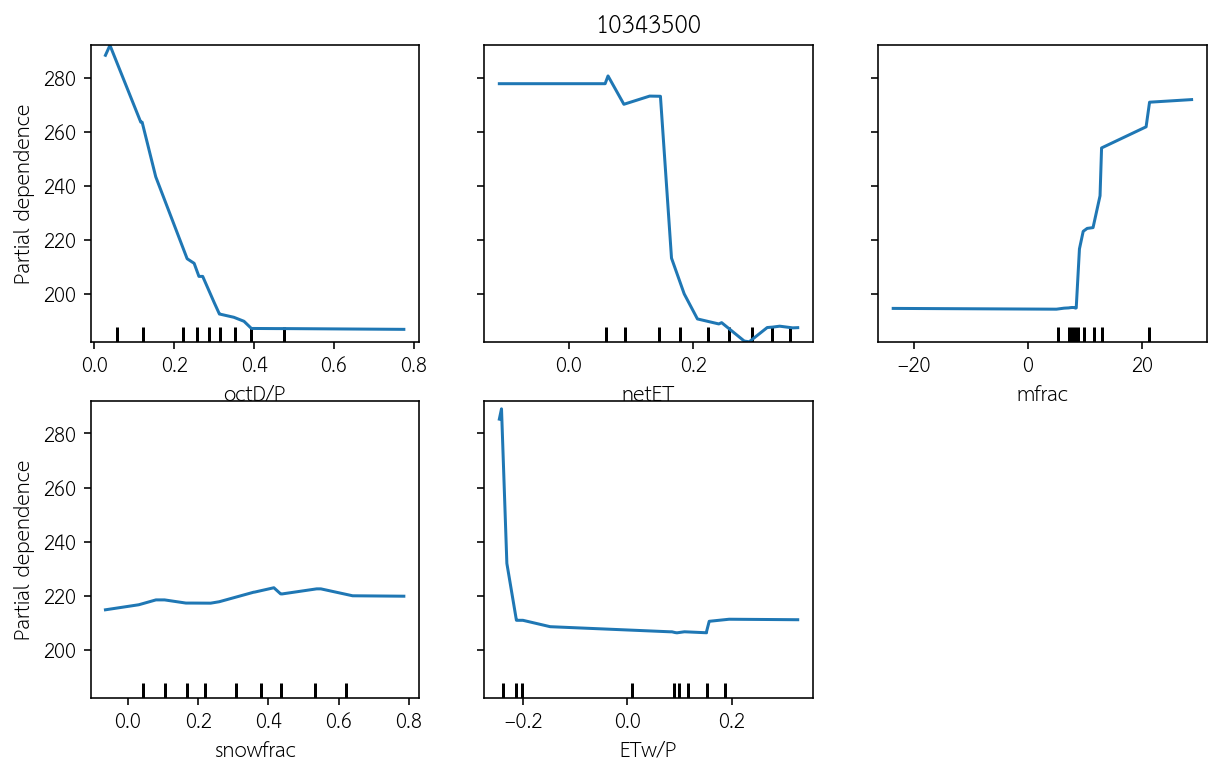


R2 = 0.91


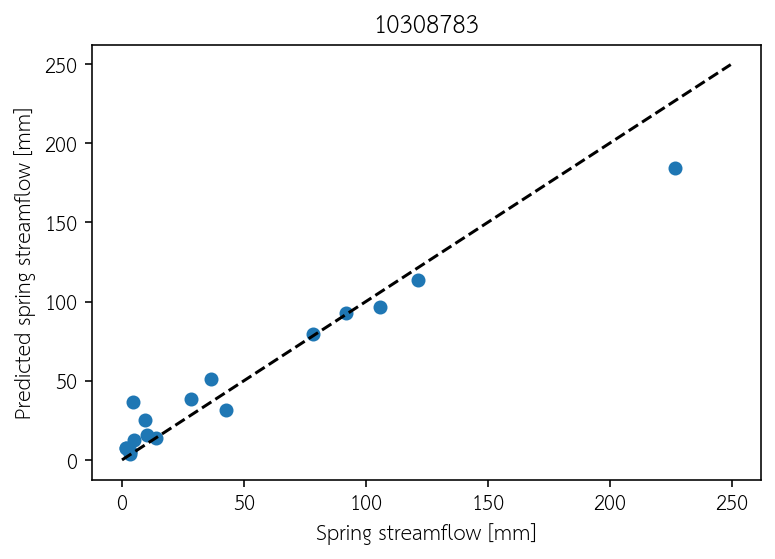

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


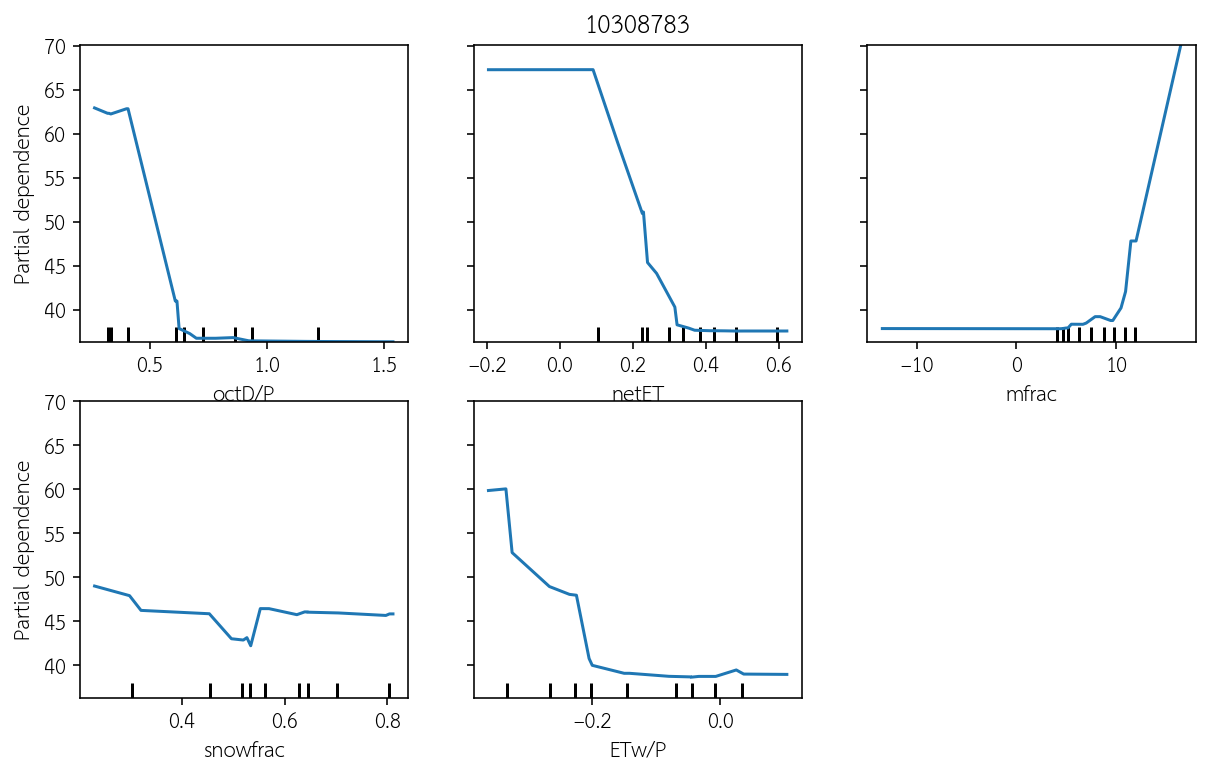


R2 = 0.86


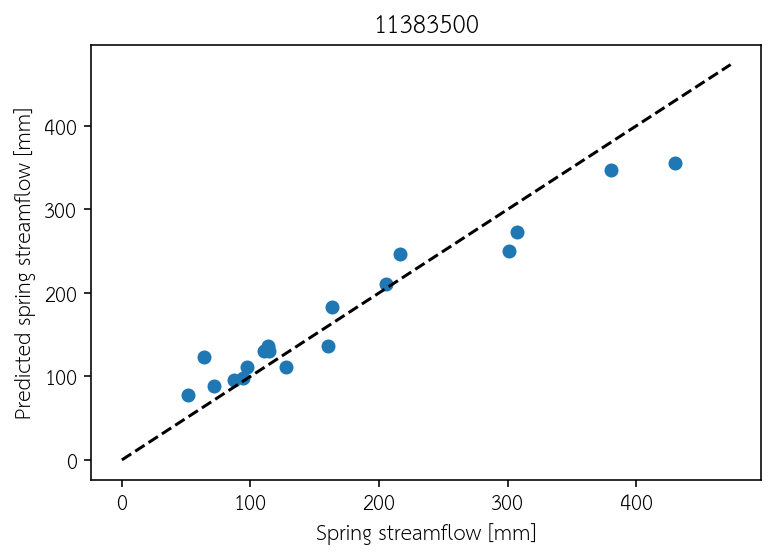

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


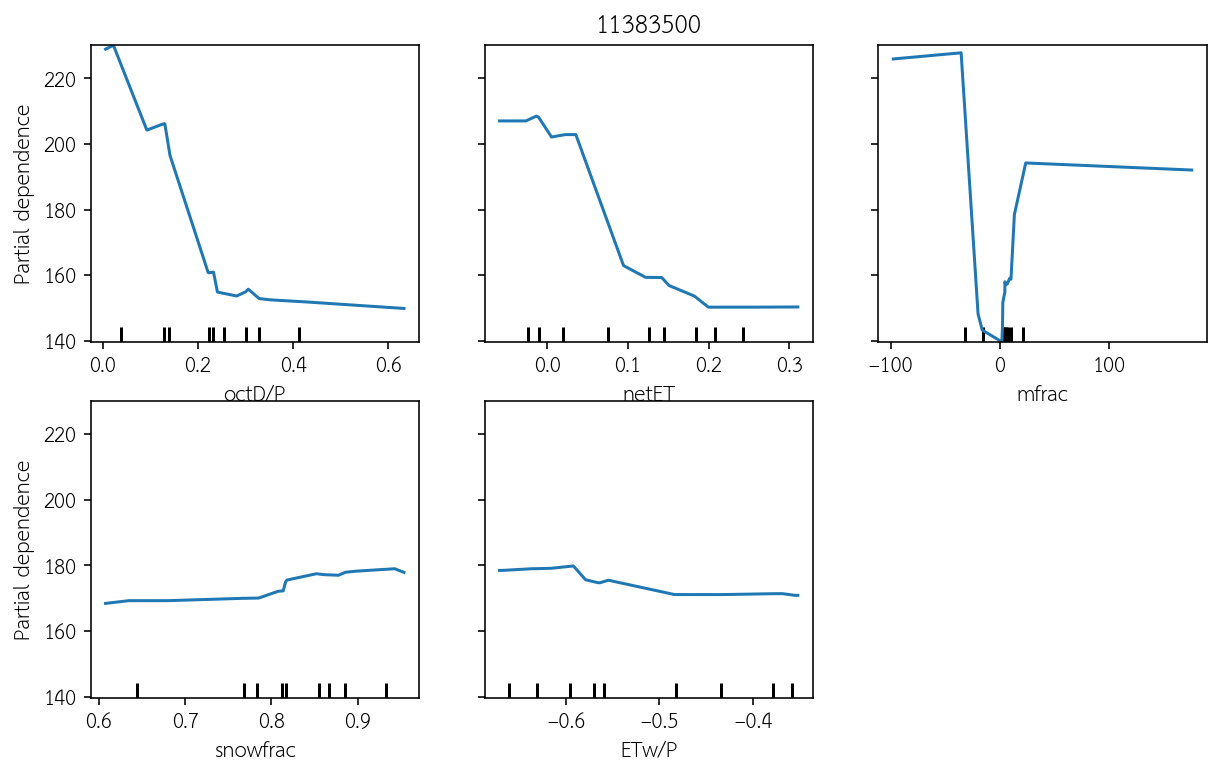


R2 = 0.97


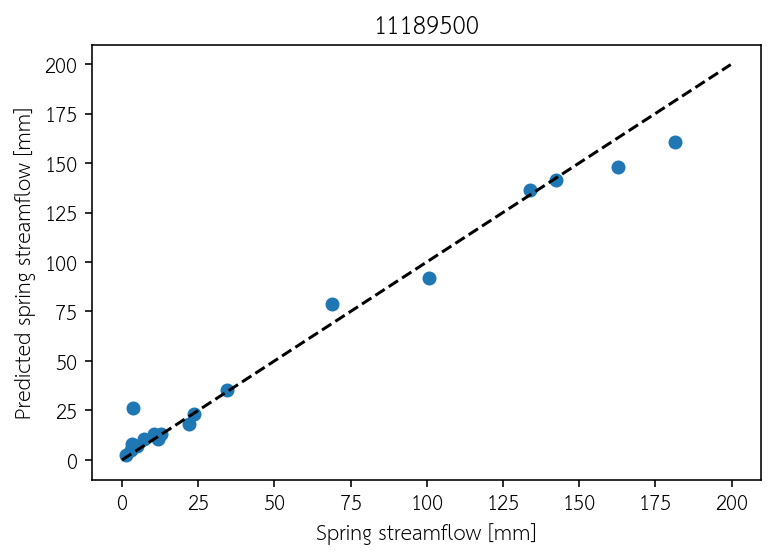

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


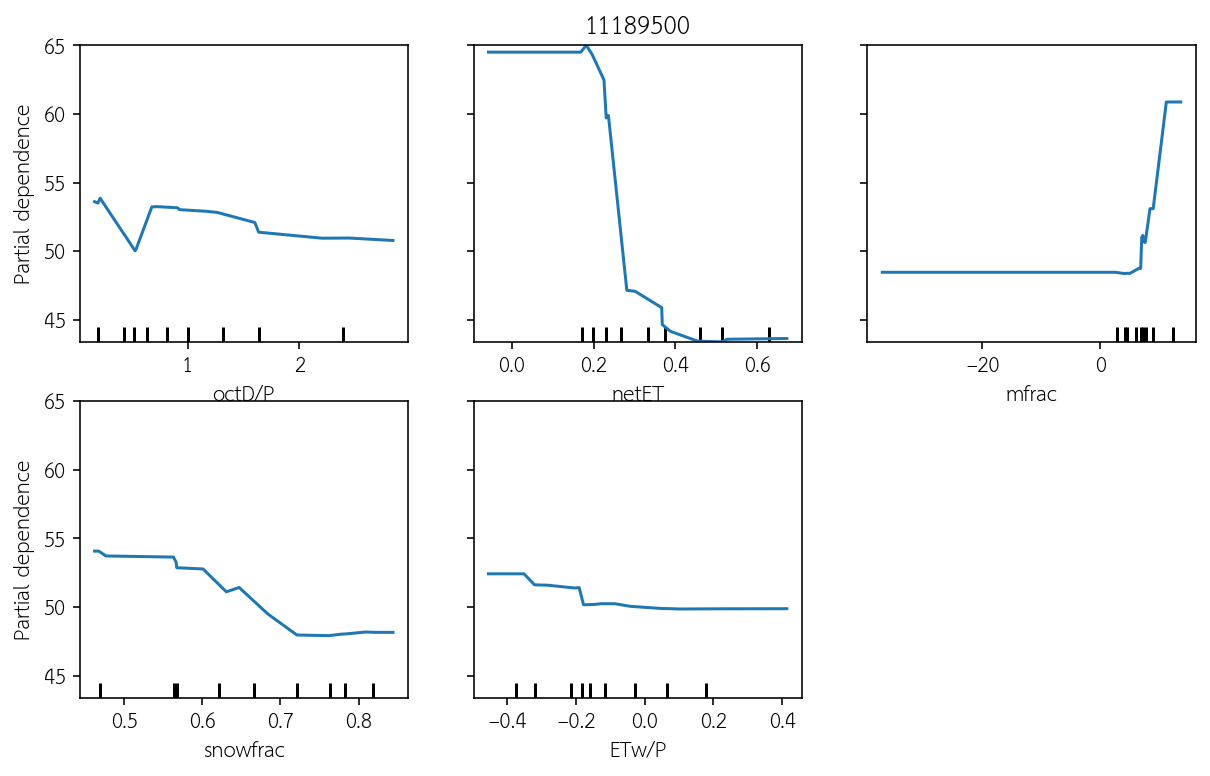


R2 = 0.88


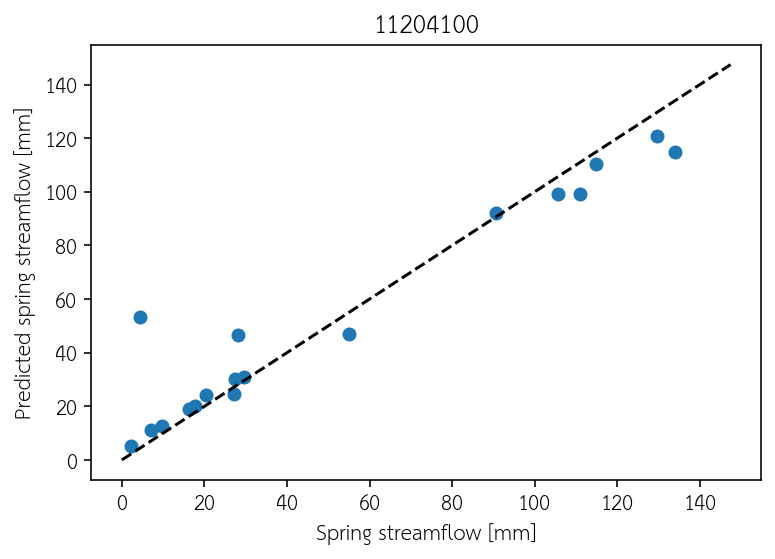

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


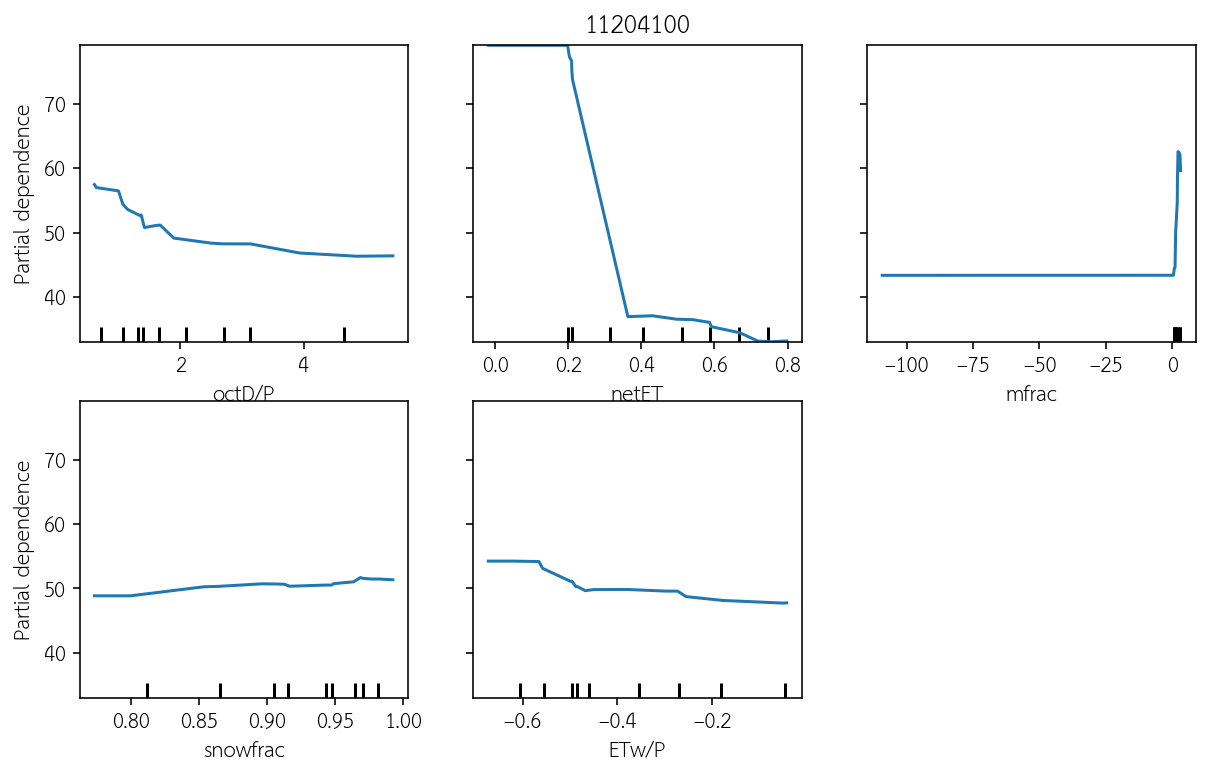


R2 = 0.95


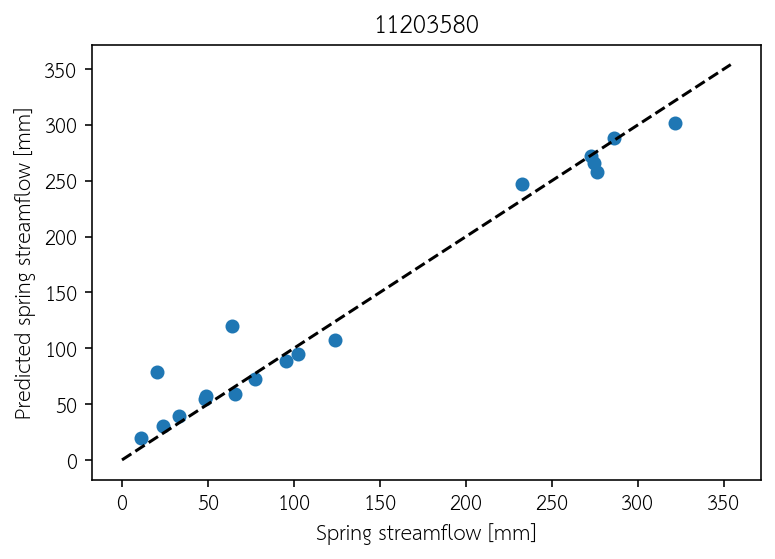

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


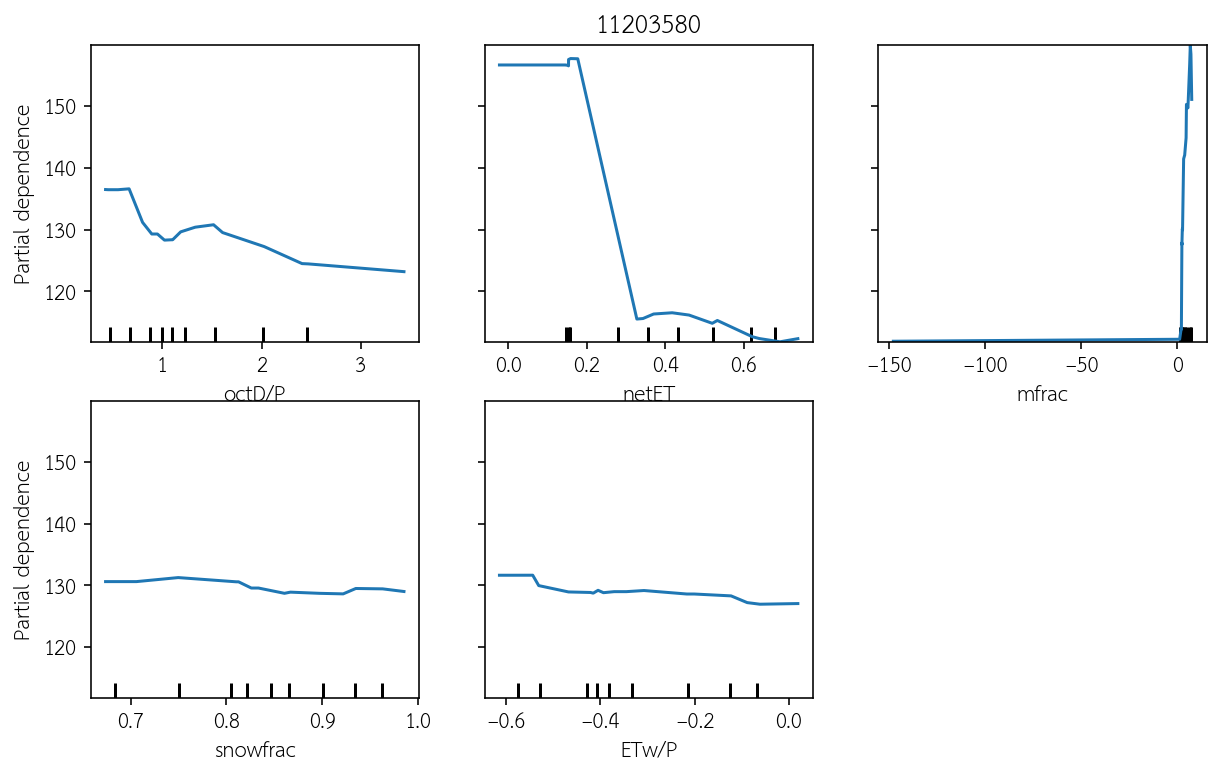


R2 = 0.97


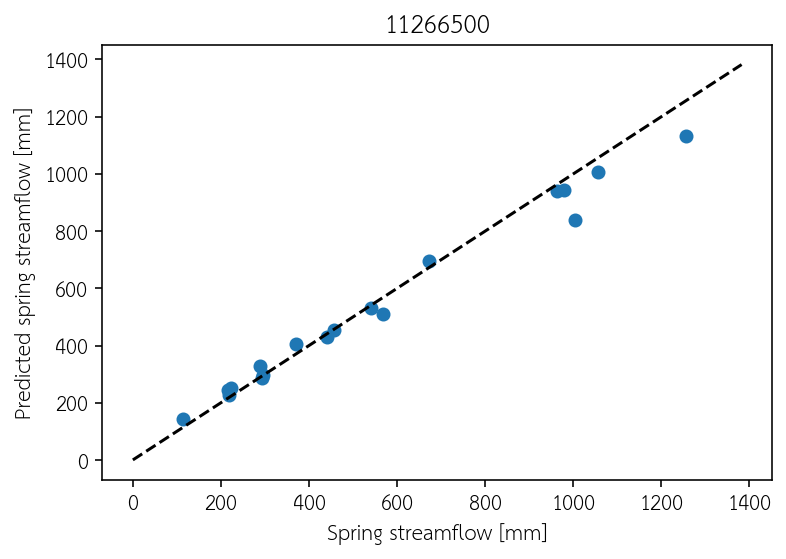

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


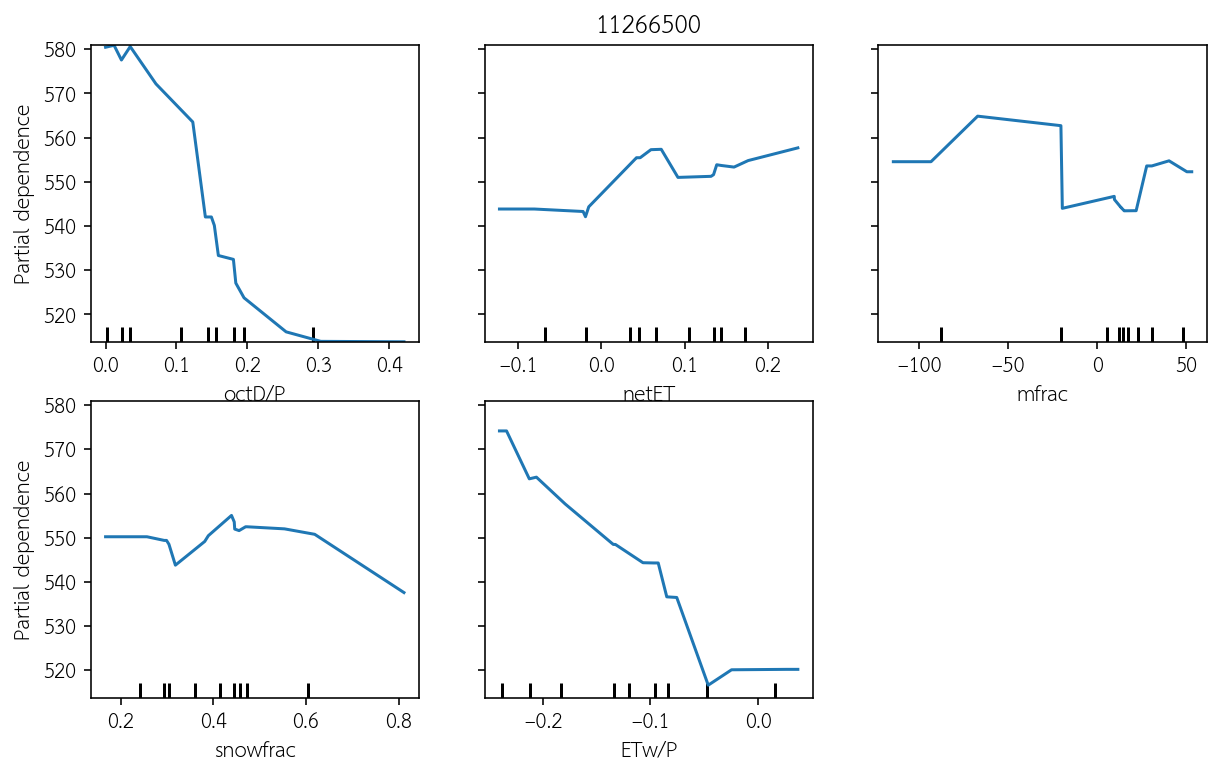


R2 = 0.93


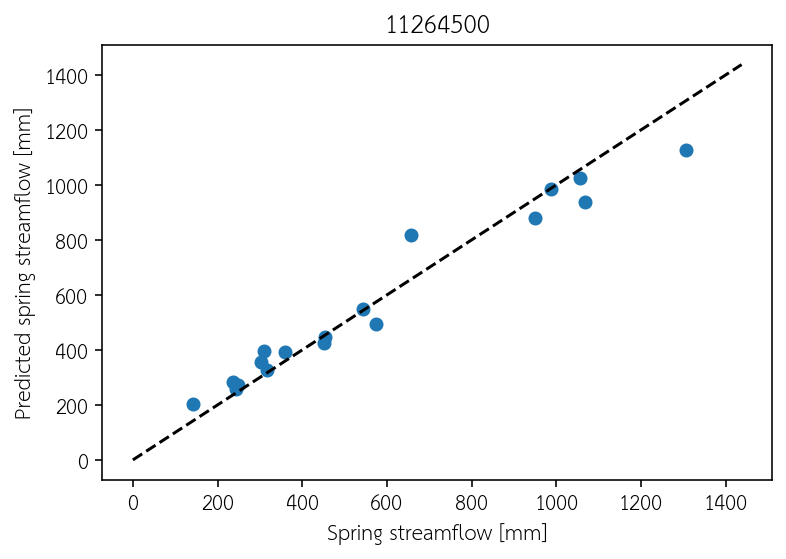

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


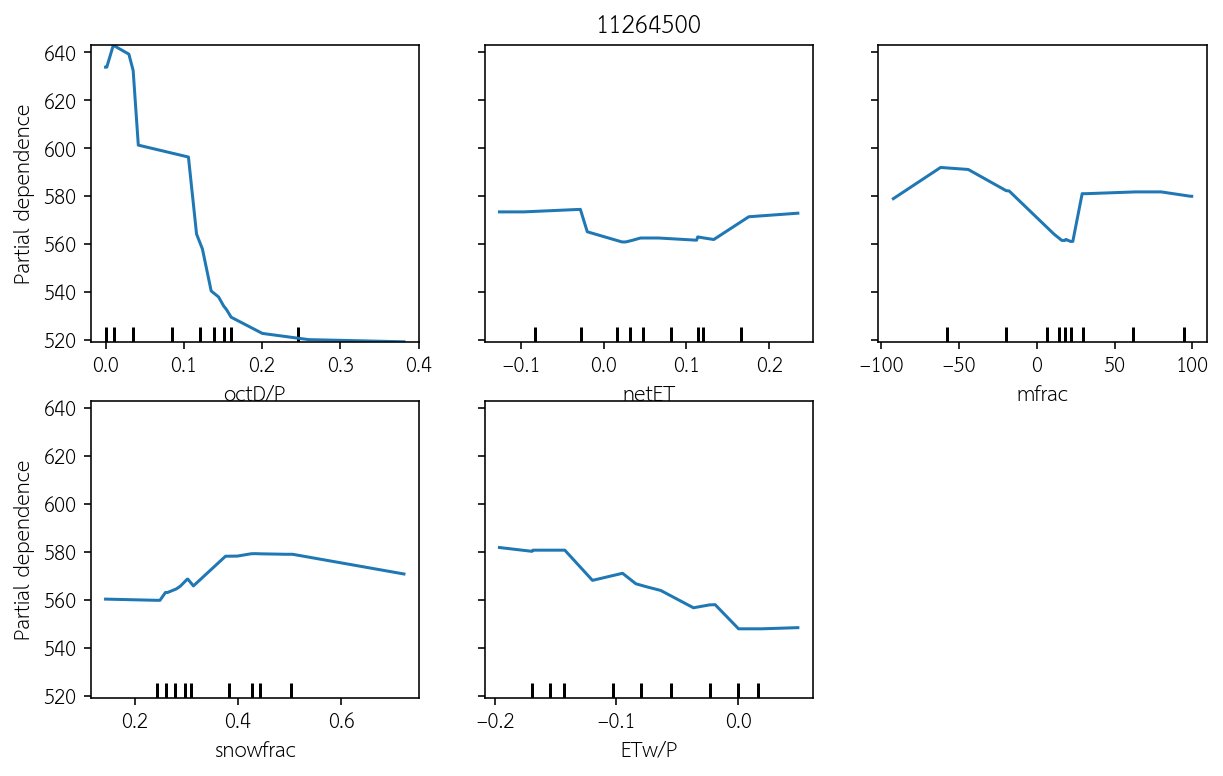


R2 = 0.92


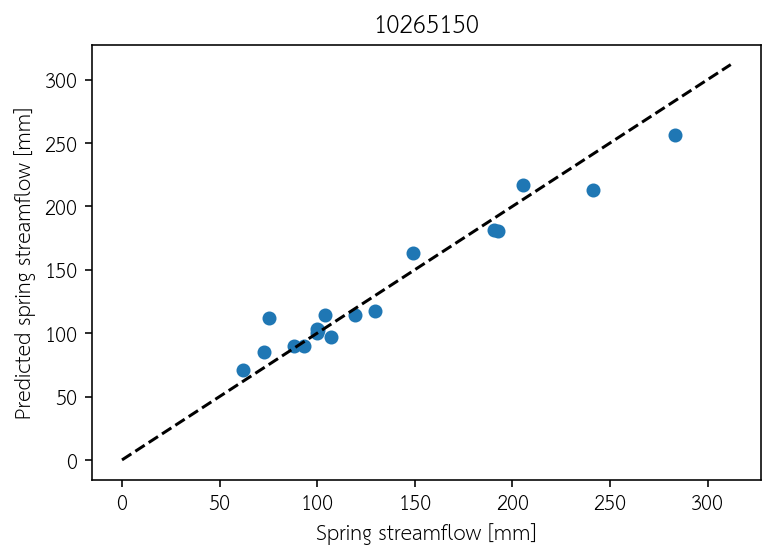

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


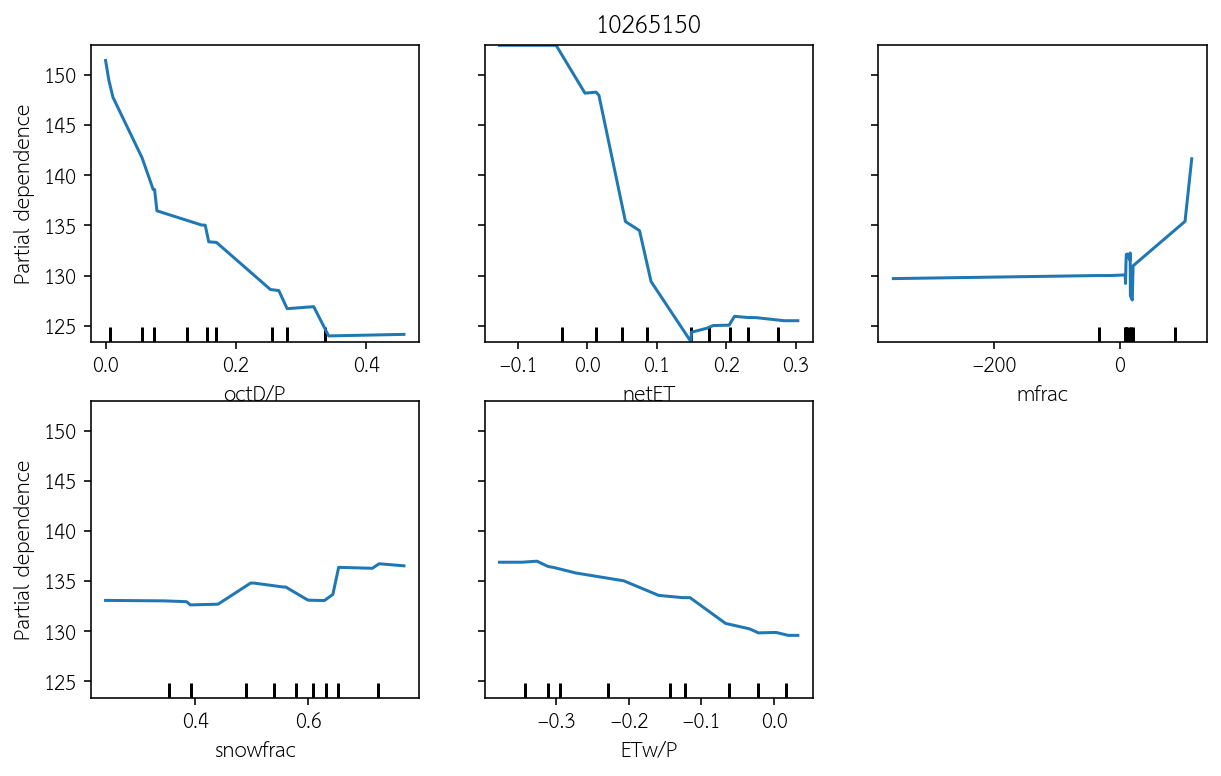

In [ ]:
# build a random forest model for each site separately--lets us see if drivers
# are different but may be a bit unreliable since there really isn't much
# data on a site-by-site basis

r2_vals = []
p2021 = []
for site in list(wy_totals.keys()):
  data = wy_totals[site]

  #define response variable
  y = data['springQ'].drop_duplicates()#data['residuals']

  data['octD/P'] = (data.octDeficit)/data.P
  data['aprD'] = (data.aprDeficit)/data.winter_P#/data.P
  data['springET/P'] = data.springET/data.P#aprSWE#data.winter_P#/data.melt_rate/120
  data['springP'] = data.spring_rain/data.P#winter_P
  data['netET'] = (data.springET-data.spring_rain)/data.P
  data['octD/wintP'] = data.octDeficit/data.winter_P
  data['m'] = data.melt_rate#*30-data.springET/4#/(data.springET-data.spring_rain)*4
  data['mfrac'] = data.melt_rate/(data.springET-data.spring_rain)*4*30
  # data['mfrac'] = np.where(np.isfinite(data.mfrac),data.mfrac,10)
  data['ETw/P'] = (data.winterET-data.winter_rain)/data.P
  data['snowfrac'] = (data.winter_rain+data.spring_rain)/data.P#

  variables_to_test = ['aprSWE','octD/P',
                      #  'octD/wintP',
                       'netET',
                       'mfrac',
                       'snowfrac',
                       'ETw/P',]
  X0 = data[variables_to_test]
  # set up model
  model = RandomForestRegressor(n_estimators=100)
  # evaluate the model
  # cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  # n_scores = cross_val_score(model, X0,y, scoring='r2', 
  #                           cv=cv, n_jobs=-1, error_score='raise')
  # print( 'MAE: %.3f (%.3f)' % ((np.nanmean(n_scores)), (np.std(n_scores))))

  # fit model to data
  clf = model.fit(X0,y)
  # get model guess for streamflow for each site/year
  y1 = model.predict(X0)

  # evaluate performance with R2
  r2_vals.append(r2_score(y1,y))
  p2021.append(y1[-1])
  print('R2 = %0.2f' %(r2_score(y1,y)))

  # plot data performance
  plt.scatter(y,y1)
  mv = max(y)*1.1
  plt.plot([0,mv],[0,mv],c='k',ls='--')
  plt.xlabel('Spring streamflow [mm]')
  plt.ylabel('Predicted spring streamflow [mm]')
  plt.title(site)
  plt.show()

  # make partial dependence plots
  fig,ax = plt.subplots(1,figsize = (10,6))
  plot_partial_dependence(clf, X0, variables_to_test[1:],ax = ax) 
  ax.set_title(site)
  plt.show()
  print('')

In [ ]:
Xcheck = {c:[] for c in X0.columns}
# for c in X0.columns:
#   Xcheck[c] = [np.nanmedian(X0[c])]*100
Xcheck['octD/P'] = np.linspace(0,3,100)
Xcheck['aprSWE'] = [100]*100
Xcheck['ETw/P'] = [1]*100
Xcheck['snowfrac'] = [0]*100
Xcheck['mfrac'] = [-1]*100
Xcheck['netET'] = [1]*100
Xcheck = pd.DataFrame.from_dict(Xcheck)
# ycheck = model.predict(Xcheck)
# plt.plot(Xcheck['octD/P'],ycheck)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


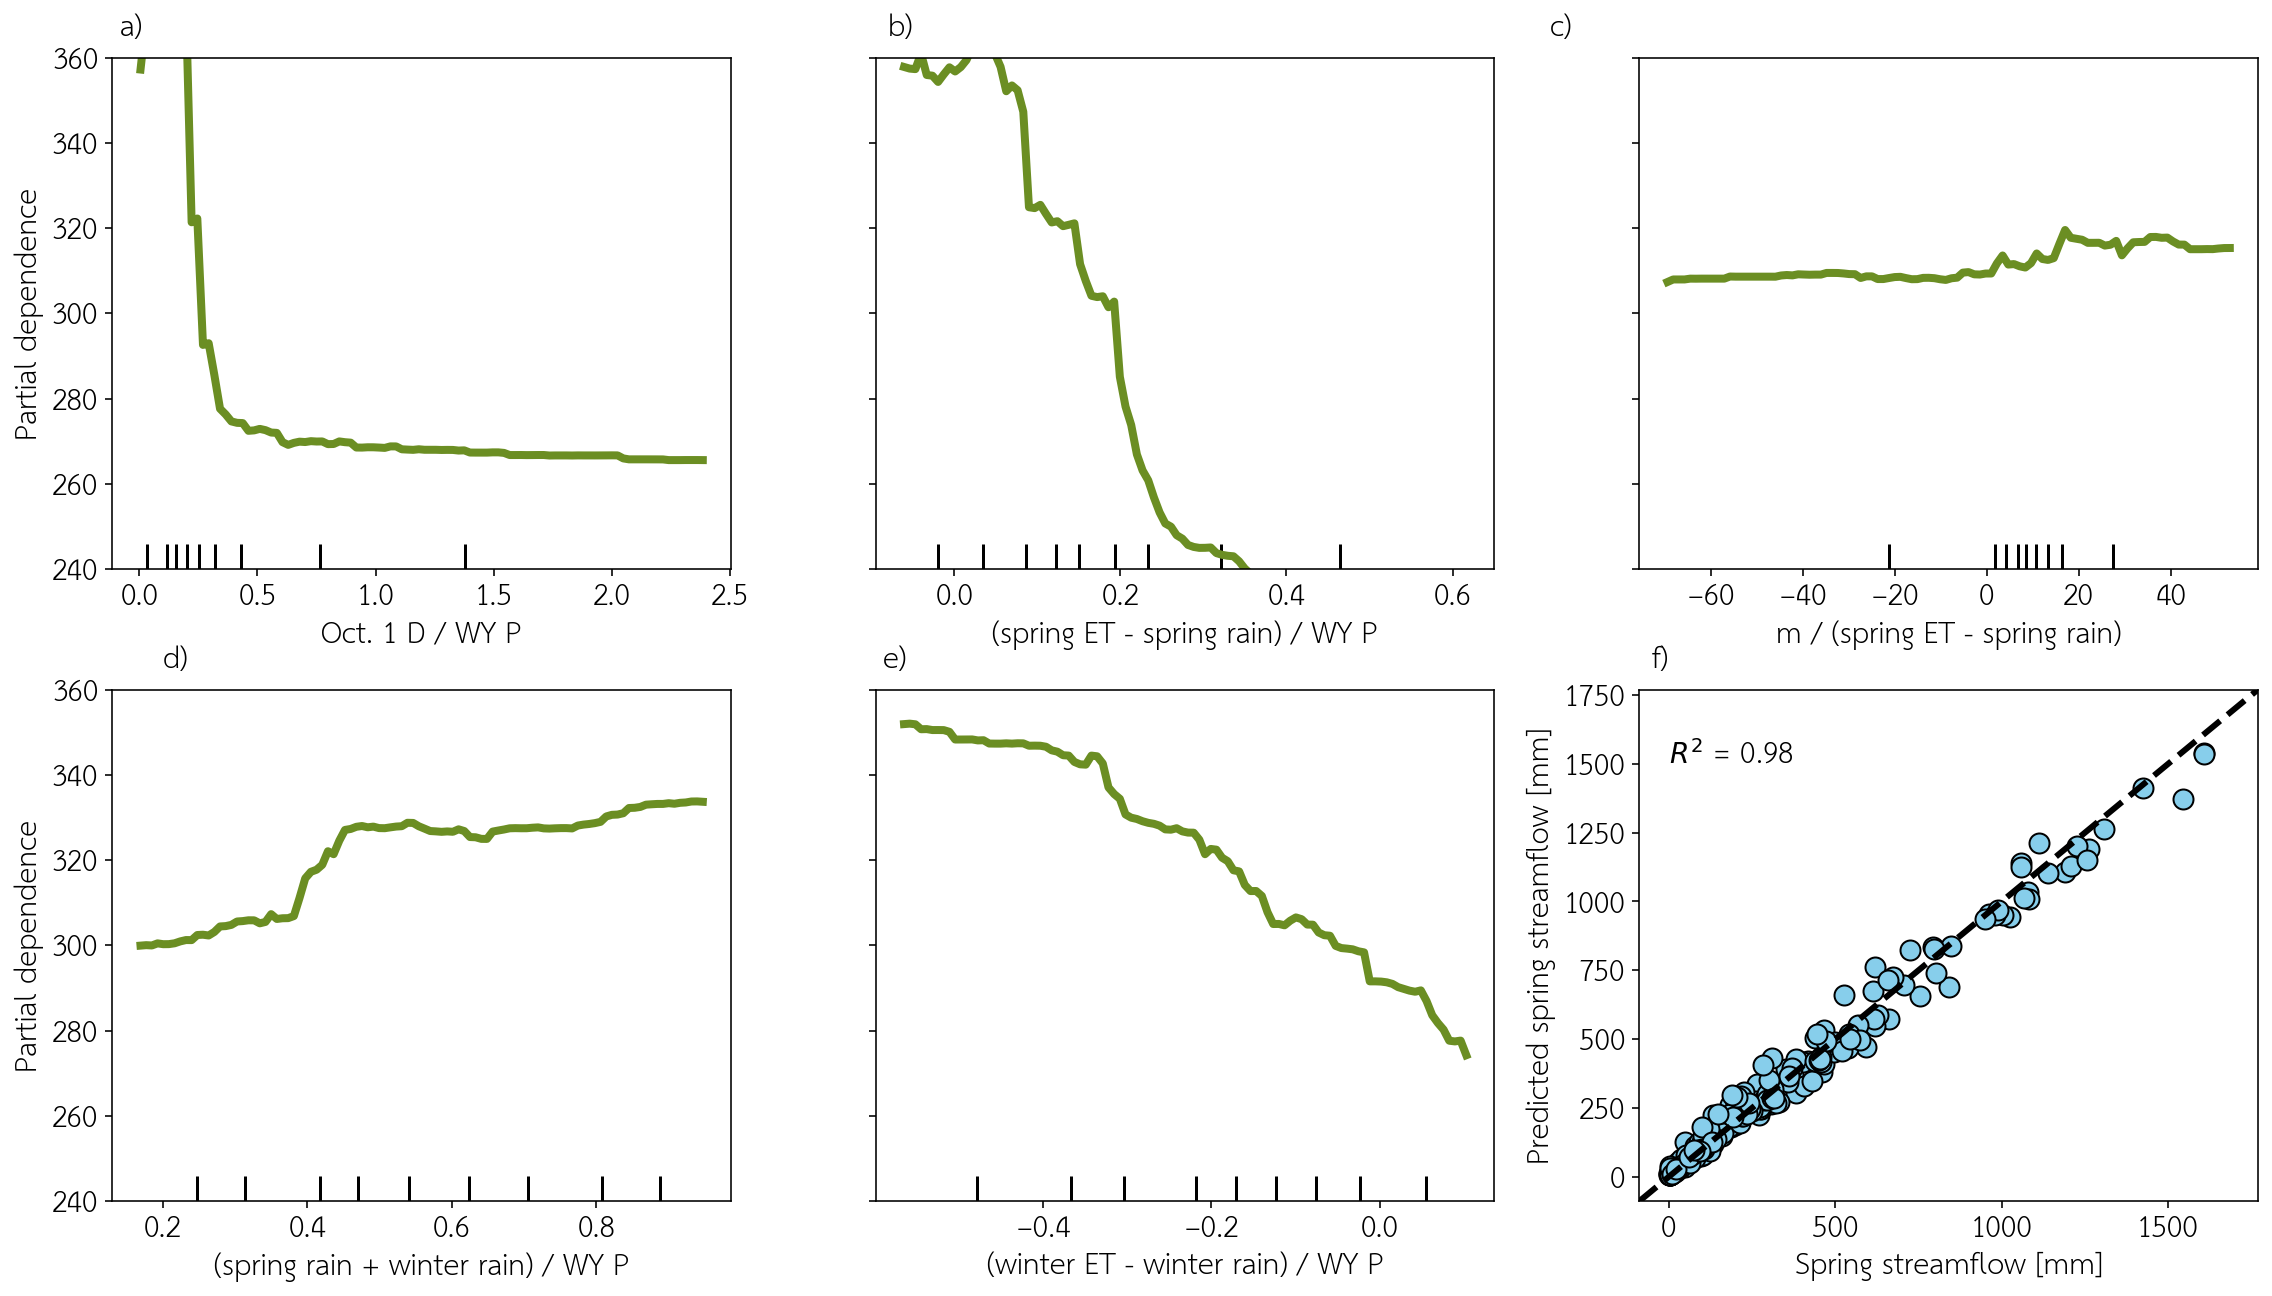

In [ ]:
# build one random forest model that functions across all sites

r2_vals = []
p2021 = []
data = ''
for site in list(wy_totals.keys()):
  if len(data)==0:
    data = wy_totals[site]
  else:
    data = pd.concat([data,wy_totals[site]])

#define response variable
y = data['springQ'].drop_duplicates()#data['residuals']

data['octD/P'] = (data.octDeficit)/data.P
data['aprD'] = (data.aprDeficit)/data.winter_P#/data.P
data['springET/P'] = data.springET/data.P#aprSWE#data.winter_P#/data.melt_rate/120
data['springP'] = data.spring_rain/data.P#winter_P
data['netET'] = (data.springET-data.spring_rain)/data.P
data['octD/wintP'] = data.octDeficit/data.winter_P
data['m'] = data.melt_rate#*30-data.springET/4#/(data.springET-data.spring_rain)*4
data['mfrac'] = data.melt_rate/(data.springET-data.spring_rain)*4*30
# data['mfrac'] = np.where(np.isfinite(data.mfrac),data.mfrac,10)
data['ETw/P'] = (data.winterET-data.winter_rain)/data.P
data['snowfrac'] = (data.winter_rain+data.spring_rain)/data.P#

variables_to_test = ['aprSWE','octD/P',
                    #  'octD/wintP',
                      'netET',
                      'mfrac',
                      'snowfrac',
                      'ETw/P',]
X0 = data[variables_to_test]

# set up model
model = RandomForestRegressor(n_estimators=100)

# fit model
model.fit(X0,y)

# get feature importance
importances = model.feature_importances_
# evaluate the model
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X0,y, scoring='r2', 
#                           cv=cv, n_jobs=-1, error_score='raise')
# print( 'MAE: %.3f (%.3f)' % ((np.nanmean(n_scores)), (np.std(n_scores))))

# fit model and calculate predicted outputs
clf = model.fit(X0,y)
y1 = model.predict(X0)

ycheck = model.predict(Xcheck)

# plot partial dependence and model performance
%matplotlib inline
plt.rcParams.update({'font.size': 14})
fig,axs = plt.subplots(2,3,figsize = (16,9))
plot_partial_dependence(clf, X0, variables_to_test[1:],ax = [axs[0,0],axs[0,1],axs[0,2],axs[1,0],axs[1,1]],
                        line_kw={"linewidth": 4, "color": "olivedrab"}) 
# ax.set_title('model for all sites')

ax = axs[1,2]
ax.scatter(y,y1,c='skyblue',s=100,edgecolor = 'k',clip_on=False)
mv = max(y)*1.1
ax.plot([-0.05*mv,mv],[-0.05*mv,mv],c='k',ls='--',lw=3)
ax.set_xlabel('Spring streamflow [mm]')
ax.set_ylabel('Predicted spring streamflow [mm]')
ax.set_xlim(-0.05*mv,mv)
ax.set_ylim(-0.05*mv,mv)
# plt.title('all sites')
# plt.show()
from sklearn.metrics import r2_score
r2_vals.append(r2_score(y1,y))
p2021.append(y1[-1])
ax.text(0,1500,'$R^2$ = %0.2f' %(r2_score(y1,y)))

for ax in [axs[0,1],axs[0,2],axs[1,1]]:
  ax.set_ylabel('')
  ax.set_yticklabels([])
fig.tight_layout()

labels = ['a)','b)','c)','d)','e)','f)']
axes = [axs[0,0],axs[0,1],axs[0,2],axs[1,0],axs[1,1],axs[1,2]]
minval = [-0.08,-0.08,-95,0.2,-0.59,-50]
xlabels = ['Oct. 1 D / WY P','(spring ET - spring rain) / WY P',
           'm / (spring ET - spring rain)',
           '(spring rain + winter rain) / WY P',
           '(winter ET - winter rain) / WY P']
for i in range(len(labels)):
  ax = axes[i]
  if i<5:
    ax.set_ylim(240,360)
    ax.text(minval[i],365,labels[i])
    ax.set_xlabel(xlabels[i])
  else:
    ax.text(minval[i],1850,labels[i])

plt.savefig('partial_dependence_all_sites.png',format='png',dpi=300)

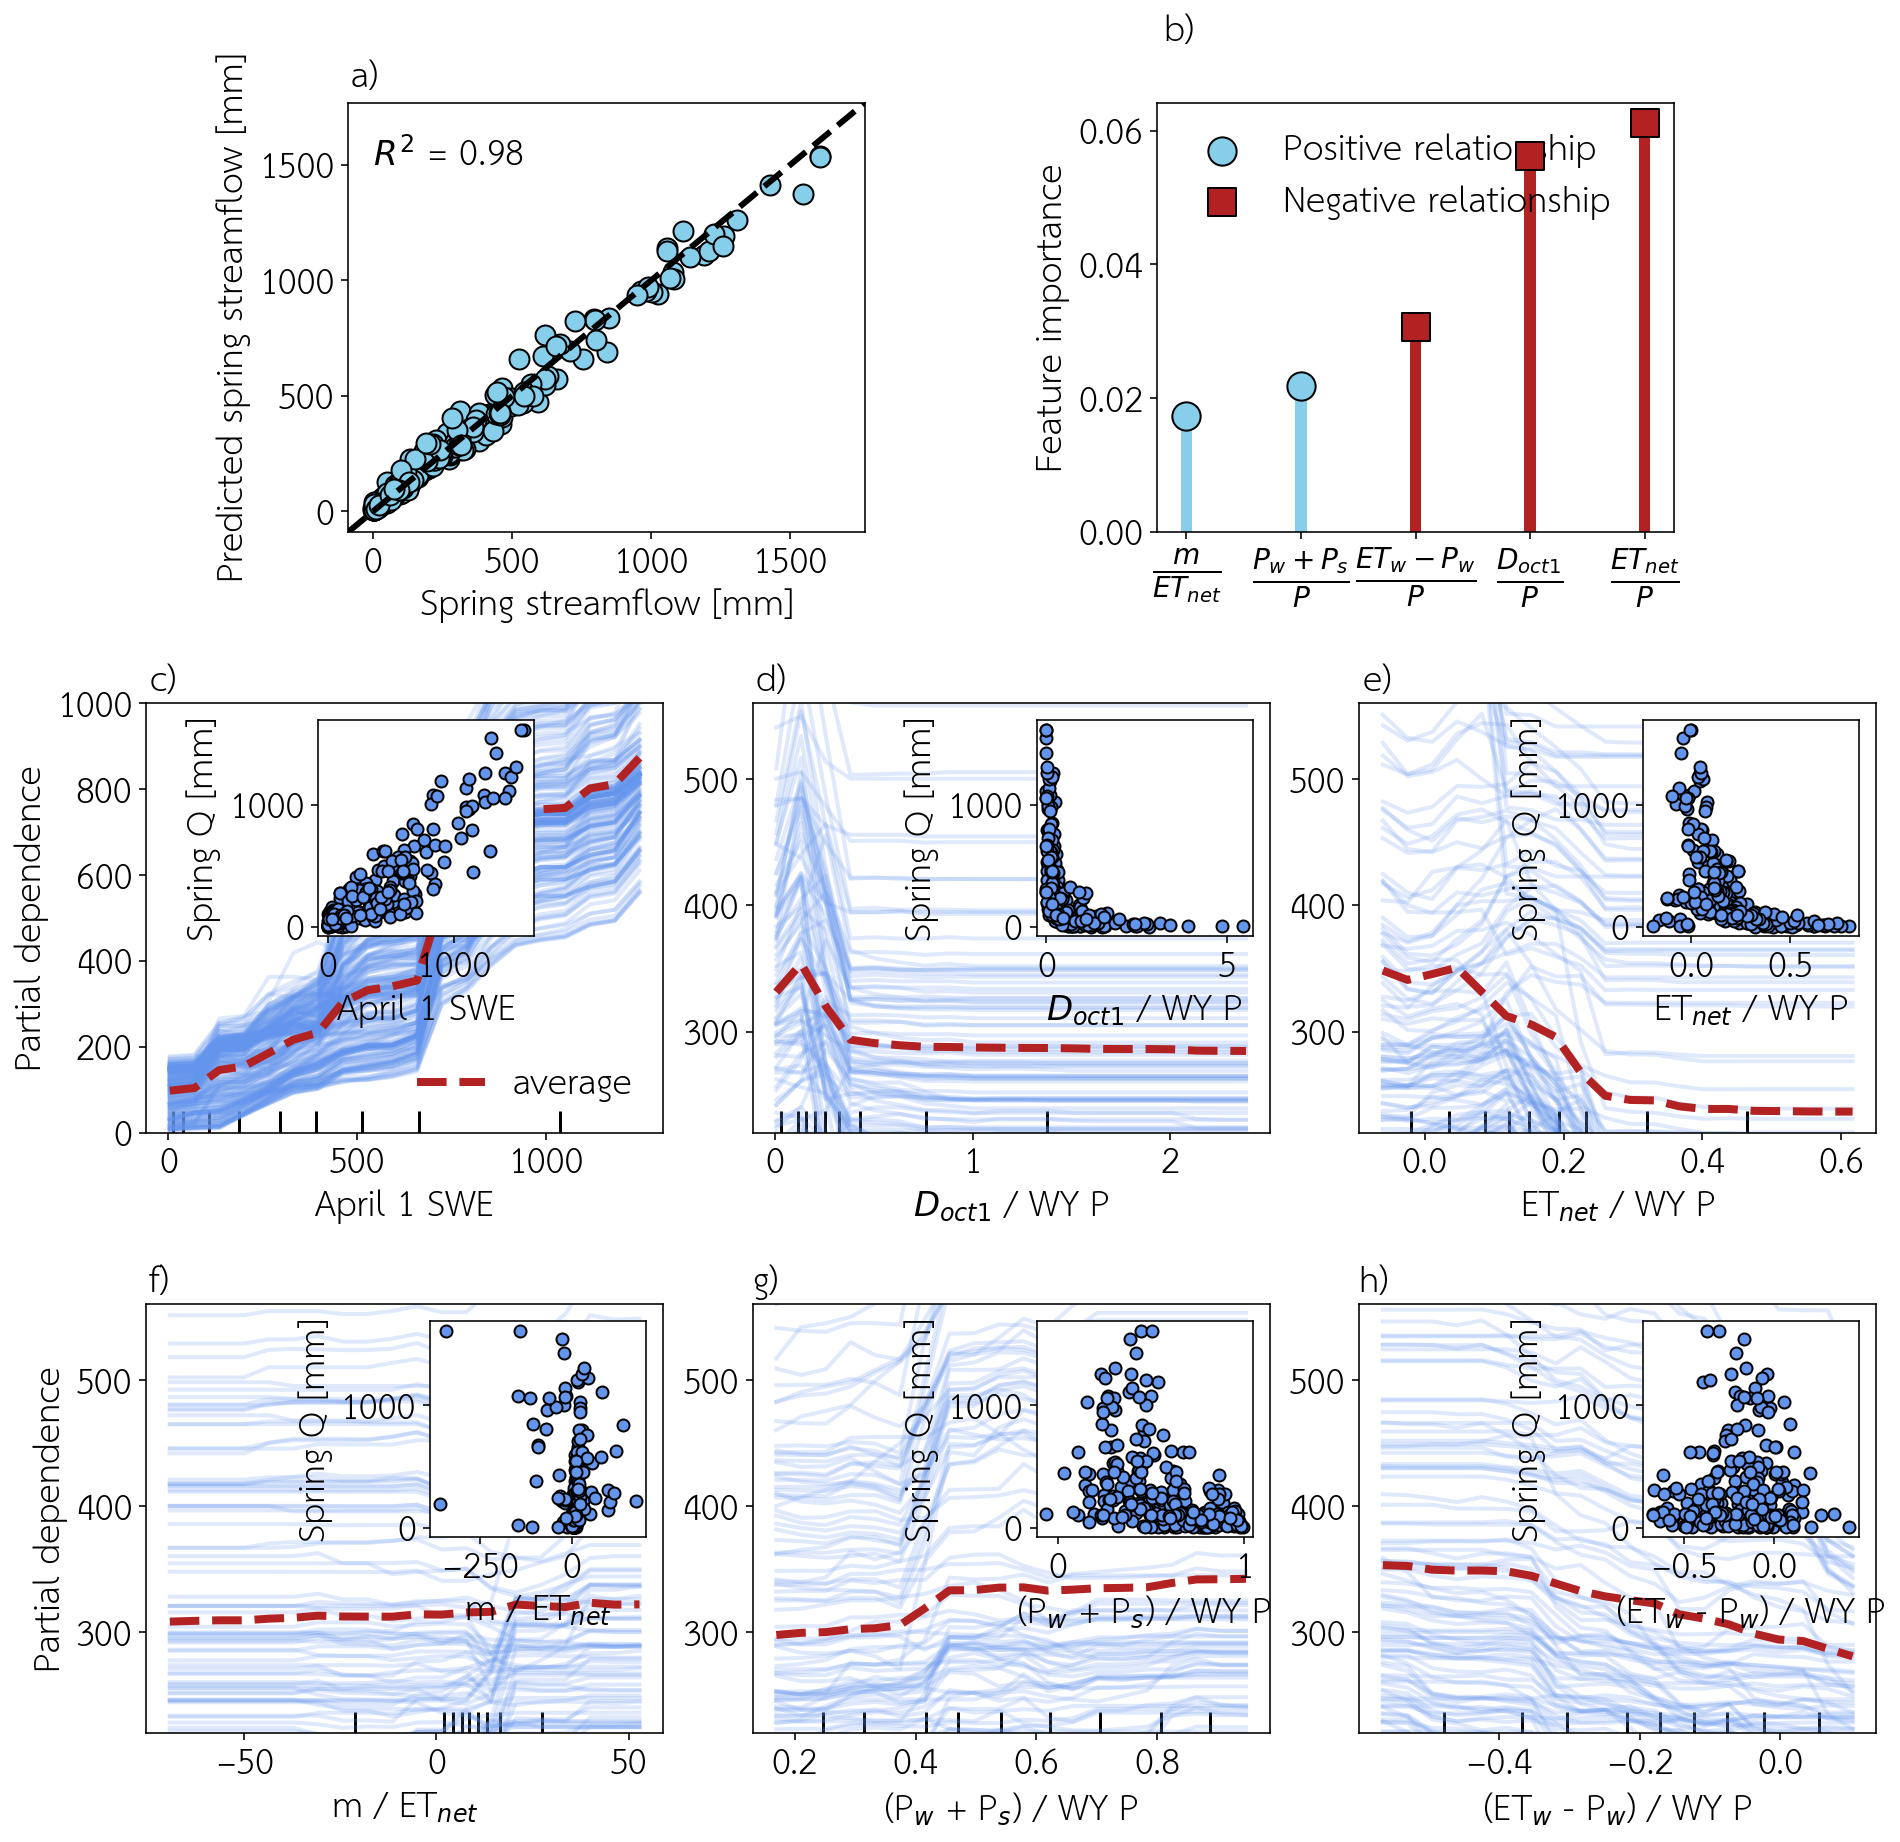

In [ ]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 17})

titles = {'aprSWE':'April 1 SWE',
          'octD/P':'$D_{oct1}$ / WY P',
          'netET':'ET$_{net}$ / WY P',
          'mfrac':'m / ET$_{net}$',
          'snowfrac':'(P$_w$ + P$_s$) / WY P',
          'ETw/P':'(ET$_{w}$ - P$_w$) / WY P'}
titles1 = {'aprSWE':'SWE',
          'octD/P':r'$\frac{D_{oct1}}{P}$',
          'netET':r'$\frac{ET_{net}}{P}$',
          'mfrac':r'$\frac{m}{ET_{net}}$',
          'snowfrac':r'$\frac{P_w + P_s}{P}$',
          'ETw/P':r'$\frac{ET_w - P_w}{P}$'}

# fig,ax = plt.subplots(2,4,figsize = (20,9))

fig = plt.figure(figsize = (15.5,15))

gs = gridspec.GridSpec(3, 9, figure=fig)
ax0 = fig.add_subplot(gs[0,1:4])
ax1 = fig.add_subplot(gs[0,5:8])
ax2 = fig.add_subplot(gs[1,:3])
ax3 = fig.add_subplot(gs[1,3:6])
ax4 = fig.add_subplot(gs[1,6:])
ax5 = fig.add_subplot(gs[2,:3])
ax6 = fig.add_subplot(gs[2,3:6])
ax7 = fig.add_subplot(gs[2,6:])

ax = [[ax0,ax2,ax3,ax4],
      [ax1,ax5,ax6,ax7]
      ]

axes = [ax[0][1],ax[0][2],ax[0][3],ax[1][1],ax[1][2],ax[1][3]]

gb = RandomForestRegressor(n_estimators=100).fit(X0, y)
# partialdep = partial_dependence(gb, features=variables_to_test, X=X0, #percentiles=(0, 1),
#                    grid_resolution=2) 

# print("Computing partial dependence plots...")
# tic = time()

features = variables_to_test
display = PartialDependenceDisplay.from_estimator(
    gb,
    X0,
    features,
    kind="both",
    # subsample=50,
    # n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ax = axes,
    ice_lines_kw={"color": "cornflowerblue", "alpha": 0.2, "linewidth": 2},
    pd_line_kw={"color": "firebrick", "linestyle": "--","linewidth":4},
)

for i in range(len(axes)):
  axes[i].set_xlabel(titles[variables_to_test[i]])
# print(f"done in {time() - tic:.3f}s")
# display.figure_.suptitle(
#     "Partial dependence of spring streamflow\n"
#     "from April 1 SWE, with MLPRegressor"
# )

for ax0 in axes:
  ax0.set_ylim(220,560)
  ax0.legend().set_visible(False)
  if ax0 != ax[1][0]:
    ax0.set_ylabel('')

ax0 = ax[0][1]
ax0.set_ylim(0,1000)
ax0.legend(frameon=False,loc='lower right')


rect_histx = [[0.175,0.838, 0.075, 0.03],
              [0.547,0.838, 0.075, 0.03],
              [0.82,0.838, 0.075, 0.03],
              [0.273,0.4, 0.075, 0.03],
              [0.547,0.4, 0.075, 0.03],
              [0.82,0.4, 0.075, 0.03],]
for i in range(len(axes)):
  # if i>0:
  ax0 = axes[i]
  if i==0:
    axins = inset_axes(ax0, width=1.5, height=1.5,loc=2,
                      bbox_to_anchor=(.3, .5, .5, .5),
                      bbox_transform=ax0.transAxes,)
  else:
    axins = inset_axes(ax0, width=1.5, height=1.5,
                      loc=1)#,
                      # bbox_to_anchor=(.5, .4, .5, .5),
                      # bbox_transform=ax0.transAxes,)
  axins.scatter(data[variables_to_test[i]],data['springQ'],
                c='cornflowerblue',edgecolor = 'k')
  axins.set_xlabel(titles[variables_to_test[i]])
  axins.set_ylabel('Spring Q [mm]')
  
  # rect_hist = rect_histx[i]
  # ax_histx = fig.add_axes(rect_hist, sharex=axins)
  # ax_histx.hist(data[variables_to_test[i]],
  #               facecolor = 'cornflowerblue',
  #               edgecolor = 'k',
  #               alpha = 0.5)
  # plt.setp(ax_histx.get_xticklabels(), visible=False)

for ax0 in [ax[0][1],ax[1][1]]:
  ax0.set_ylabel('Partial dependence')


ax0 = ax[0][0]
ax0.scatter(y,y1,c='skyblue',s=100,edgecolor = 'k',clip_on=False)
mv = max(y)*1.1
ax0.plot([-0.05*mv,mv],[-0.05*mv,mv],c='k',ls='--',lw=3)
ax0.set_xlabel('Spring streamflow [mm]')
ax0.set_ylabel('Predicted spring streamflow [mm]')
ax0.set_xlim(-0.05*mv,mv)
ax0.set_ylim(-0.05*mv,mv)
# plt.title('all sites')
# plt.show()
from sklearn.metrics import r2_score
r2_vals.append(r2_score(y1,y))
p2021.append(y1[-1])
ax0.text(0,1500,'$R^2$ = %0.2f' %(r2_score(y1,y)))

ax0 = ax[1][0]
poscolor = 'skyblue'
negcolor = 'firebrick'
pos = ['snowfrac','mfrac',]
neg = ['octD/P','ETw/P','netET',]



label_importance = sorted(zip(importances,X0.columns))
ax0.bar([x for z,x in label_importance if x in pos],
        [z for z,x in label_importance if x in pos],width = 0.1,
        facecolor = poscolor)
ax0.scatter([x for z,x in label_importance if x in pos],
        [z for z,x in label_importance if x in pos],s=200,
        c = poscolor,marker='o',edgecolor = 'k',zorder = 10,
        label='Positive relationship')
ax0.bar([x for z,x in label_importance if x in neg],
        [z for z,x in label_importance if x in neg],width = 0.1,
        facecolor = negcolor)
ax0.scatter([x for z,x in label_importance if x in neg],
        [z for z,x in label_importance if x in neg],s=200,
        c = negcolor,marker='s',edgecolor = 'k',zorder = 10,
        label = 'Negative relationship')
ax0.set_xticklabels([titles1[x] for z,x in label_importance],fontsize = 20)
ax0.legend(loc='upper left',frameon=False)
# ax0.set_xticklabels(['$m/ET_{net}$',
#           '$(P_w+P_s)/P$',
#           '$(ET_w-P_w)/P$',
#           '$D_{oct1}/P$',
#           '$(ET_s-P_s)/P$'])
ax0.set_ylabel('Feature importance')

letters = ['a)','c)','d)','e)',
          'b)','f)','g)','h)']
xv = [-80,-50,-.1,-0.09,
      -0.2,-75,0.13,-0.6]
yv1 = 570
yv = [1840,1030,yv1,yv1,
      0.0735,yv1,yv1,yv1]
axes1 = [ax[0][0],ax[0][1],ax[0][2],ax[0][3],
         ax[1][0],ax[1][1],ax[1][2],ax[1][3]]

for i in range(len(axes1)):
  axes1[i].text(xv[i],yv[i],letters[i])

display.figure_.subplots_adjust(wspace=0.8, hspace=0.4)

# plt.subplots_adjust(hspace = 0.6, wspace = 0.6)

plt.savefig('random_forest_results.png',format='png',bbox_inches='tight',dpi=300)

## Use multiple linear regression to examine relative importance of proposed mechanisms

In [ ]:
# do single regression with all parameters included

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score

results1 = {'site':[],
           'Apr 1 SWE':[],
           'Oct D':[],
           'Apr D/P':[],
           'Oct D/wintP':[],
           'max D/P':[],
           'Apr D':[],
           'ET':[],
           'netET':[],
           'mfrac':[],
           'springP':[],
           'm':[],
           'ETw/P':[],
           'snowfrac':[],
           'const':[],
           'r2':[],
           'justSWE_r2':[],
           'pred2021':[],
           'pred2021_SWE':[],
           'Q2021':[],
           'SWE_D_only_r2':[],
           'pred2021_SWE_D':[],
            'pred2006':[],
            'pred2006_SWE':[],
            'Q2006':[],
            'pred2006_SWE_D':[],
            'r2wet':[]
           }
results_dry = {'site':[],
           'Apr 1 SWE':[],
           'Oct D':[],
           'Apr D/P':[],
           'Oct D/wintP':[],
           'max D/P':[],
           'Apr D':[],
           'ET':[],
           'netET':[],
           'mfrac':[],
           'springP':[],
           'm':[],
           'ETw/P':[],
           'snowfrac':[],
           'const':[],
           'r2':[],
           'justSWE_r2':[],
           'pred2021':[],
           'pred2021_SWE':[],
           'Q2021':[],
           'SWE_D_only_r2':[],
           'pred2021_SWE_D':[],
            'pred2006':[],
            'pred2006_SWE':[],
            'Q2006':[],
            'pred2006_SWE_D':[],
            'r2dry':[]
           }

for site in gages.SITE_NO.values:
  data = wy_totals[site]

  #define response variable
  y = data['springQ'].drop_duplicates()#data['residuals']

  data['octD/P'] = (data.octDeficit)/data.P
  data['residuals'] = residuals[site]
  # data['maxD/P'] = data.maxDeficit/data.P
  data['aprD'] = (data.aprDeficit)/data.winter_P#/data.P
  data['springET/P'] = data.springET/data.P#aprSWE#data.winter_P#/data.melt_rate/120
  data['springP'] = data.spring_rain/data.P#winter_P
  data['netET'] = (data.springET-data.spring_rain)/data.P
  # data['netET']
  # data['input_flux_term'] = (data.adjP-data.springET)/data.melt_rate
  # data['fluxdiff'] = (data.springET)/data.P#-data.spring_rain)/data.P
  data['octD/wintP'] = data.octDeficit/data.winter_P
  data['m'] = data.melt_rate#*30-data.springET/4#/(data.springET-data.spring_rain)*4
  data['mfrac'] = data.melt_rate/(data.springET-data.spring_rain)*4*30
  data['mfrac'] = np.where(np.isfinite(data.mfrac),data.mfrac,10)
  data['ETw/P'] = (data.winterET-data.winter_rain)/data.P
  # data['aprD/P'] = data.aprDeficit/data.P
  data['snowfrac'] = (data.winter_rain+data.spring_rain)/data.P#
  data['wintP'] = data.winter_rain/data.P

  variables_to_test = ['aprSWE',
                       'octD/P',
                      #  'springET/P',
                      # 'springP',
                      #  'm',
                      #  'octD/wintP',
                       'netET',
                       'mfrac',
                       'snowfrac',
                       'ETw/P',
                      #  'aprD/P'
                      #  'aprD'
                       ]#,'octD/wintP',]
  
  r2vals_big = []
  pred2021_big = []
  pred2006_big = []


  x = data[[p for p in variables_to_test]].drop_duplicates()

  #add constant to predictor variables
  x = sm.add_constant(x)

  xy = x.merge(y,left_index=True,right_index=True).dropna()
  # xy['residuals'] = residuals[site]

  #fit regression model
  model = sm.OLS(xy['springQ'], xy.drop(columns='springQ')).fit()
  # model = sm.OLS(xy['residuals'], xy.drop(columns=['residuals',site])).fit()

  r2vals_big.append(model.rsquared)
  
  pred2021_big.append(np.sum(model.params.values*x.iloc[-1].values.flatten()))
  pred2006_big.append(np.sum(model.params.values*x.iloc[-16].values.flatten()))

  # do just with April 1 SWE now

  x = data[[p for p in variables_to_test[:1]]].drop_duplicates()

  #add constant to predictor variables
  x = sm.add_constant(x)

  xy = x.merge(y,left_index=True,right_index=True).dropna()
  # xy['residuals'] = residuals[site]

  #fit regression model
  model1 = sm.OLS(xy['springQ'], xy.drop(columns='springQ')).fit()
  # model = sm.OLS(xy['residuals'], xy.drop(columns=['residuals',site])).fit()

  P75 = np.nanpercentile(data.P,75)
  P25 = np.nanpercentile(data.P,25)
  wet_years = data[data.P>P75].index.values
  dry_years = data[data.P<P25].index.values
  wet_years = [i+1 for i in wet_years]
  dry_years = [i+1 for i in dry_years if i!=2021]

  r2valswe = (model1.rsquared)
  preds = (model1.params.values*x).sum(axis=1)
  try:
    wetyr_pred = preds.loc[wet_years].values
    actualwet = y.loc[wet_years].values.flatten()
  except:
    wetyr_pred = preds.loc[[w for w in wet_years if w != 2015]].values
    actualwet = y.loc[[w for w in wet_years if w != 2015]].values.flatten()
  dryyr_pred = preds.loc[dry_years].values
  actualdry = y.loc[dry_years].values.flatten()
  r2_wet = r2_score(wetyr_pred,actualwet)
  r2_dry = r2_score(dryyr_pred,actualdry)
  
  pred2021swe = (np.sum(model1.params.values*x.iloc[-1].values.flatten()))
  pred2006swe = (np.sum(model1.params.values*x.iloc[-16].values.flatten()))


  # do just with April 1 SWE and D now

  x = data[[p for p in ['aprSWE','octD/wintP']]].drop_duplicates()

  #add constant to predictor variables
  x = sm.add_constant(x)

  xy = x.merge(y,left_index=True,right_index=True).dropna()
  # xy['residuals'] = residuals[site]

  #fit regression model
  model2 = sm.OLS(xy['springQ'], xy.drop(columns='springQ')).fit()
  # model = sm.OLS(xy['residuals'], xy.drop(columns=['residuals',site])).fit()

  r2valswed = (model2.rsquared)
  
  pred2021swed = (np.sum(model2.params.values*x.iloc[-1].values.flatten()))
  pred2006swed = (np.sum(model2.params.values*x.iloc[-16].values.flatten()))
  


  # print(r2vals)
  bestparams = variables_to_test
  compare_params = model.params.to_frame()
  paramdict = model.params.to_dict()
  paramdict = {'params':list(paramdict.keys()),
               'value':[paramdict[p] for p in paramdict.keys()]}
  compare_params_dry = pd.DataFrame.from_dict(paramdict).set_index('params')

  

  
  
  # dry_years = [2008,2009,2012,2013,2014,2015,2020,2021]
  # wet_years = [2006,2007,2011,2017,2019]
  for param in compare_params.index:
    if param=='const':
      print('')
    else:
      compare_params.loc[param] = compare_params.loc[param]*abs(np.nanmedian(data[param].loc[wet_years]))
      compare_params_dry.loc[param] = compare_params_dry.loc[param]*abs(np.nanmedian(data[param].loc[dry_years]))
  print('term importance comparison:',compare_params)
  print('')

  

  # save effect size for each parameter included in model
  results1['site'].append(site)
  if 'aprSWE' in bestparams:
    results1['Apr 1 SWE'].append(compare_params.loc['aprSWE'].values[0])
  else:
    results1['Apr 1 SWE'].append(0)
  if 'octD/P' in bestparams:
    results1['Oct D'].append(compare_params.loc['octD/P'].values[0])
  else:
    results1['Oct D'].append(0)
  if 'aprD/P' in bestparams:
    results1['Apr D/P'].append(compare_params.loc['aprD/P'].values[0])
  else:
    results1['Apr D/P'].append(0)
  if 'maxD/P' in bestparams:
    results1['max D/P'].append(compare_params.loc['maxD/P'].values[0])
  else:
    results1['max D/P'].append(0)
  if 'octD/wintP' in bestparams:
    results1['Oct D/wintP'].append(compare_params.loc['octD/wintP'].values[0])
  else:
    results1['Oct D/wintP'].append(0)
  if 'aprD' in bestparams:
    results1['Apr D'].append(compare_params.loc['aprD'].values[0])
  else:
    results1['Apr D'].append(0)
  if 'm' in bestparams:
    results1['m'].append(compare_params.loc['m'].values[0])
  else:
    results1['m'].append(0)
  if 'mfrac' in bestparams:
    results1['mfrac'].append(compare_params.loc['mfrac'].values[0])
  else:
    results1['mfrac'].append(0)
  if 'springET/P' in bestparams:
    results1['ET'].append(compare_params.loc['springET/P'].values[0])
  else:
    results1['ET'].append(0)
  if 'ETw/P' in bestparams:
    results1['ETw/P'].append(compare_params.loc['ETw/P'].values[0])
  else:
    results1['ETw/P'].append(0)
  if 'snowfrac' in bestparams:
    results1['snowfrac'].append(compare_params.loc['snowfrac'].values[0])
  else:
    results1['snowfrac'].append(0)
  if 'netET' in bestparams:
    results1['netET'].append(compare_params.loc['netET'].values[0])
  else:
    results1['netET'].append(0)
  if 'springP' in bestparams:
    results1['springP'].append(compare_params.loc['springP'].values[0])
  else:
    results1['springP'].append(0)
  results1['const'].append(compare_params.loc['const'].values[0])
  results1['r2'].append(model.rsquared)
  results1['justSWE_r2'].append(r2valswe)
  results1['SWE_D_only_r2'].append(r2valswed)
  results1['pred2021'].append(pred2021_big[-1])
  results1['pred2006'].append(pred2006_big[-1])
  results1['pred2006_SWE'].append(pred2006swe)
  results1['pred2021_SWE'].append(pred2021swe)
  results1['pred2021_SWE_D'].append(pred2021swed)
  results1['pred2006_SWE_D'].append(pred2006swed)
  results1['Q2021'].append(data.springQ.values[-1])
  results1['Q2006'].append(data.springQ.values[-16])
  results1['r2wet'].append(r2_wet)

  results_dry['site'].append(site)
  if 'aprSWE' in bestparams:
    results_dry['Apr 1 SWE'].append(compare_params_dry.loc['aprSWE'].values[0])
  else:
    results_dry['Apr 1 SWE'].append(0)
  if 'octD/P' in bestparams:
    results_dry['Oct D'].append(compare_params_dry.loc['octD/P'].values[0])
  else:
    results_dry['Oct D'].append(0)
  if 'aprD/P' in bestparams:
    results_dry['Apr D/P'].append(compare_params_dry.loc['aprD/P'].values[0])
  else:
    results_dry['Apr D/P'].append(0)
  if 'maxD/P' in bestparams:
    results_dry['max D/P'].append(compare_params_dry.loc['maxD/P'].values[0])
  else:
    results_dry['max D/P'].append(0)
  if 'octD/wintP' in bestparams:
    results_dry['Oct D/wintP'].append(compare_params_dry.loc['octD/wintP'].values[0])
  else:
    results_dry['Oct D/wintP'].append(0)
  if 'aprD' in bestparams:
    results_dry['Apr D'].append(compare_params_dry.loc['aprD'].values[0])
  else:
    results_dry['Apr D'].append(0)
  if 'm' in bestparams:
    results_dry['m'].append(compare_params_dry.loc['m'].values[0])
  else:
    results_dry['m'].append(0)
  if 'mfrac' in bestparams:
    results_dry['mfrac'].append(compare_params_dry.loc['mfrac'].values[0])
  else:
    results_dry['mfrac'].append(0)
  if 'springET/P' in bestparams:
    results_dry['ET'].append(compare_params_dry.loc['springET/P'].values[0])
  else:
    results_dry['ET'].append(0)
  if 'ETw/P' in bestparams:
    results_dry['ETw/P'].append(compare_params_dry.loc['ETw/P'].values[0])
  else:
    results_dry['ETw/P'].append(0)
  if 'snowfrac' in bestparams:
    results_dry['snowfrac'].append(compare_params_dry.loc['snowfrac'].values[0])
  else:
    results_dry['snowfrac'].append(0)
  if 'netET' in bestparams:
    results_dry['netET'].append(compare_params_dry.loc['netET'].values[0])
  else:
    results_dry['netET'].append(0)
  if 'springP' in bestparams:
    results_dry['springP'].append(compare_params_dry.loc['springP'].values[0])
  else:
    results_dry['springP'].append(0)
  # results_dry['const'].append(compare_params_dry.loc['const'].values[0])
  results_dry['r2'].append(model.rsquared)
  results_dry['justSWE_r2'].append(r2valswe)
  results_dry['SWE_D_only_r2'].append(r2valswed)
  results_dry['pred2021'].append(pred2021_big[-1])
  results_dry['pred2006'].append(pred2006_big[-1])
  results_dry['pred2006_SWE'].append(pred2006swe)
  results_dry['pred2021_SWE'].append(pred2021swe)
  results_dry['pred2021_SWE_D'].append(pred2021swed)
  results_dry['pred2006_SWE_D'].append(pred2006swed)
  results_dry['Q2021'].append(data.springQ.values[-1])
  results_dry['Q2006'].append(data.springQ.values[-16])
  results_dry['r2dry'].append(r2_dry)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi


term importance comparison:                    0
const    -149.010269
aprSWE    176.126547
octD/P    -39.301348
netET       4.364389
mfrac      -0.580518
snowfrac  125.601039
ETw/P      -1.871554


term importance comparison:                    0
const      18.249667
aprSWE    368.474962
octD/P    -49.685774
netET     -20.541767
mfrac      -6.008492
snowfrac  105.822174
ETw/P     -38.323521


term importance comparison:                    0
const     157.713128
aprSWE    410.428854
octD/P   -111.005948
netET     -76.138181
mfrac       6.713627
snowfrac   27.550513
ETw/P    -193.341358



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi


term importance comparison:                    0
const     -69.857114
aprSWE    428.795077
octD/P    -99.850409
netET     -69.077251
mfrac       2.273397
snowfrac  212.107731
ETw/P     -84.237864


term importance comparison:                    0
const    -125.955250
aprSWE    264.719948
octD/P    -58.529197
netET       1.089704
mfrac     -31.250660
snowfrac   73.827422
ETw/P     -34.543269


term importance comparison:                   0
const     50.495384
aprSWE    13.157899
octD/P   -34.341657
netET    -64.115277
mfrac     24.016048
snowfrac  19.526705
ETw/P     -3.549186



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi


term importance comparison:                    0
const    -122.796022
aprSWE     37.426215
octD/P    -55.017830
netET     -39.150428
mfrac      -1.243584
snowfrac  223.705040
ETw/P     -58.008195


term importance comparison:                   0
const     45.025305
aprSWE    22.459415
octD/P    -0.256086
netET    -20.646221
mfrac      8.081554
snowfrac -34.106391
ETw/P     -6.374623


term importance comparison:                    0
const     -88.840443
aprSWE      7.095841
octD/P    -16.605951
netET     -52.296467
mfrac       0.582539
snowfrac  219.817194
ETw/P       5.858402



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi


term importance comparison:                    0
const      12.712575
aprSWE     23.726884
octD/P    -24.335741
netET     -77.619725
mfrac       4.105441
snowfrac  168.260507
ETw/P     -24.612242


term importance comparison:                    0
const     -25.663318
aprSWE    288.298720
octD/P    -61.973915
netET     -40.958444
mfrac      14.881274
snowfrac   87.128090
ETw/P     -28.944678


term importance comparison:                    0
const     -14.028816
aprSWE    276.472061
octD/P    -50.647271
netET     -39.655941
mfrac       7.414647
snowfrac  115.437808
ETw/P      -1.208717


term importance comparison:                    0
const     142.087799
aprSWE     15.537304
octD/P    -18.012685
netET     -32.312678
mfrac       0.524156
snowfrac    6.988657
ETw/P      -7.551430



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


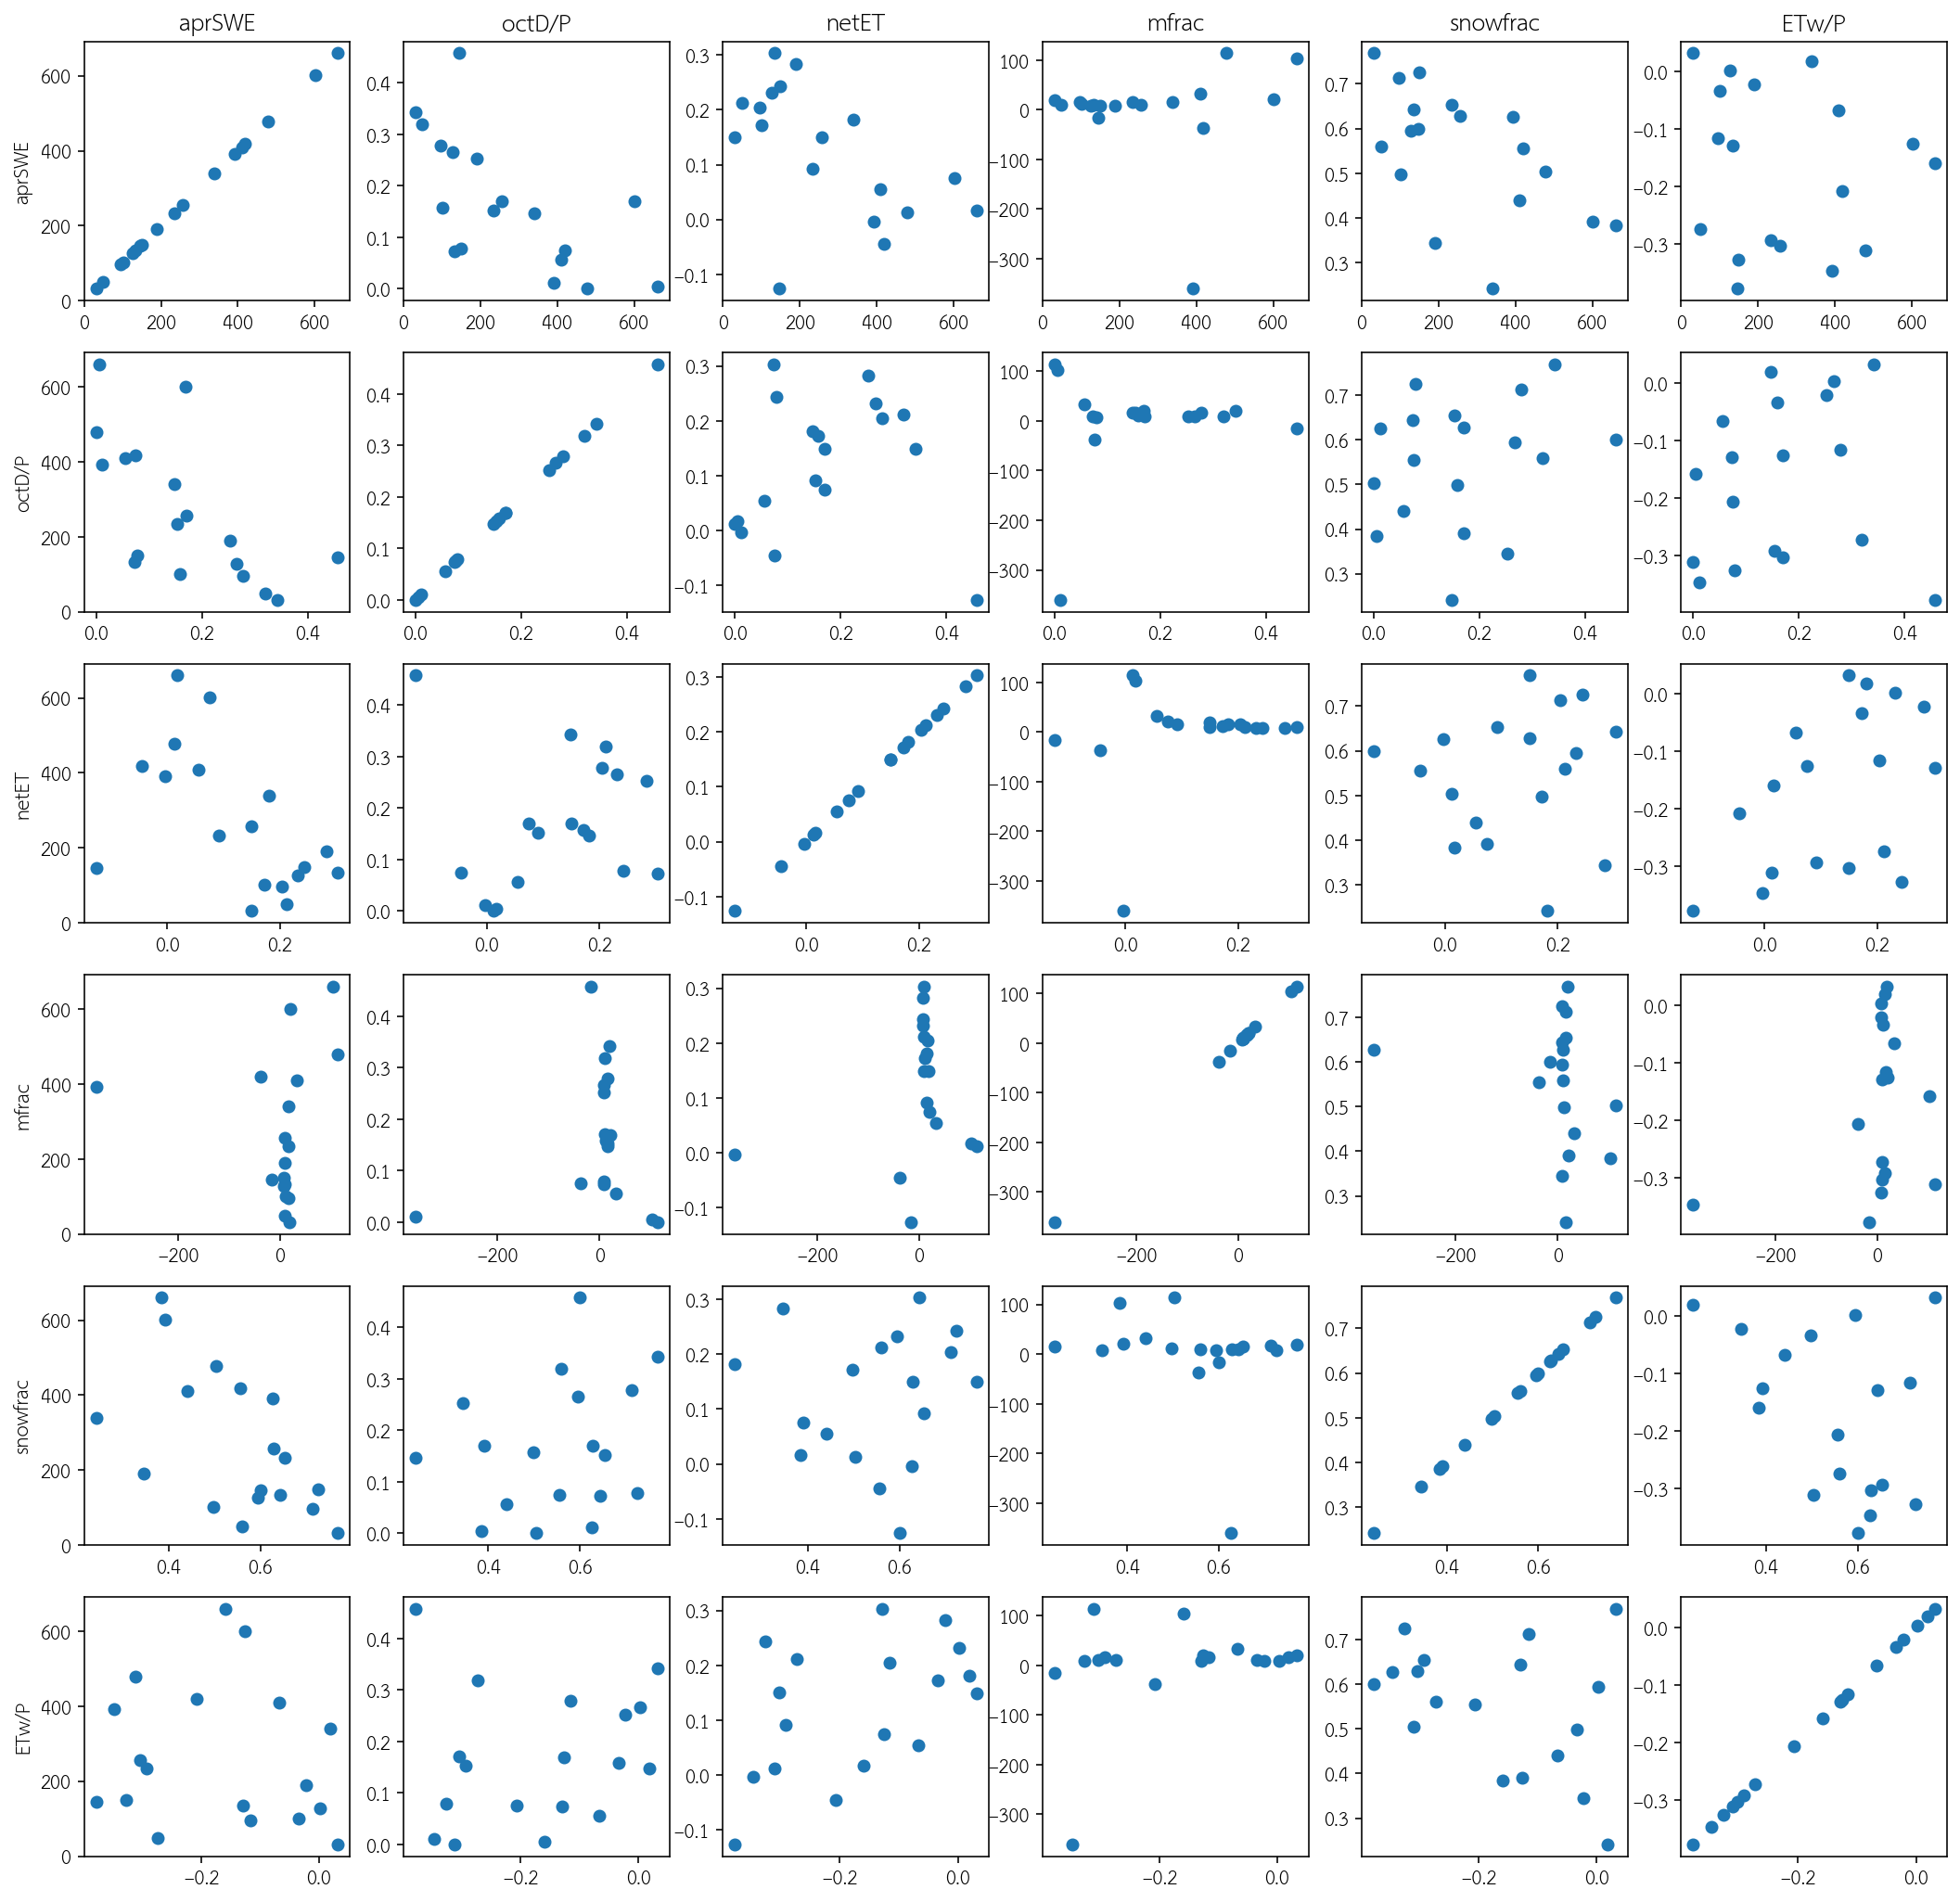

In [ ]:
# plot all variables against each other
# correlated variables will make this approach less reliable
# some variables are a little bit correlated, but I messed around with this a lot
# and this is the best we can do

fig,axs = plt.subplots(len(variables_to_test),len(variables_to_test),
                      figsize = (3*len(variables_to_test),3*len(variables_to_test)))

for i in range(len(variables_to_test)):
  for j in range(len(variables_to_test)):
    ax = axs[i][j]
    ax.scatter(data[variables_to_test[i]],data[variables_to_test[j]])
    if i==0:
      ax.set_title(variables_to_test[j])
    if j==0:
      ax.set_ylabel(variables_to_test[i])



In [ ]:
# print out results
df= pd.DataFrame.from_dict(results1)
results_dry.pop('const')
df_dry= pd.DataFrame.from_dict(results_dry)
df['percent_diff'] = -(df.Q2021-df.pred2021)/df.Q2021*100
df_dry['percent_diff'] = -(df_dry.Q2021-df_dry.pred2021)/df_dry.Q2021*100
df = df[['site','Apr 1 SWE','snowfrac','const','Oct D','netET','ETw/P','mfrac',
        #  'percent_diff',
         'r2','SWE_D_only_r2','justSWE_r2','r2wet'
        #  'pred2021','Q2021','pred2021_SWE_D'
         ]]
df_dry = df_dry[['site','Apr 1 SWE','snowfrac',
                #  'const',
                 'Oct D','netET','ETw/P','mfrac',
        #  'percent_diff',
         'r2','SWE_D_only_r2','justSWE_r2','r2dry'
        #  'pred2021','Q2021','pred2021_SWE_D'
         ]]
# print(df_dry.to_latex(float_format='%2.0f',index=False))
df_dry

site   Apr 1 SWE    snowfrac       Oct D       netET       ETw/P  \
0   10336780  258.514094  105.845893  -62.891837    2.408044  -11.833336   
1   10336645  423.204217   64.014654  -94.710268  -18.881662  -12.658619   
2   10336660  512.648681   24.377447 -201.872545  -45.200551 -156.033785   
3   10336676  573.167918  191.997838 -189.267371  -34.325224  -79.690633   
4   10343500  285.248709   61.835375  -82.750982    1.036851  -11.746098   
5   10308783   12.603315   19.197302  -52.406068  -41.577534   -4.040864   
6   11383500   63.306972  210.691674  -47.009667  -47.588019  -70.361333   
7   11189500   15.566367  -33.890310   -0.671189  -20.363470   -2.497790   
8   11204100    2.882173  226.971246  -41.692357  -79.385893    5.729764   
9   11203580    8.524730  186.865674  -56.696207 -122.828566  -22.258749   
10  11266500  396.962446   74.576332 -106.516757  -28.108856  -41.301009   
11  11264500  390.515546   93.894062  -89.371270  -24.774050   -7.323464   
12  10265150   22.055262    7.050397  -57.788669  -20.880187   -1.273758   

        mfrac        r2  SWE_D_only_r2  justSWE_r2      r2dry  
0   -0.832027  0.942800       0.897219    0.865146   0.125734  
1   -6.955968  0.930243       0.898881    0.878104   0.403969  
2    9.413254  0.956680       0.927377    0.873693   0.510936  
3    2.915661  0.979701       0.949892    0.883906   0.555502  
4  -30.043405  0.975311       0.788304    0.728587   0.295149  
5   27.195428  0.865729       0.644169    0.630227  -0.205296  
6   -0.948421  0.782211       0.583956    0.491749  -1.198463  
7    5.931490  0.872992       0.846682    0.828206  -0.745790  
8    0.293142  0.905439       0.716786    0.485330 -25.054691  
9    1.982484  0.915152       0.733577    0.636478  -8.105775  
10  17.421100  0.957986       0.915156    0.907874   0.752556  
11   9.168461  0.929768       0.899163    0.894438   0.843623  
12   0.618853  0.805220       0.709340    0.652912  -0.226956

In [ ]:
(df.SWE_D_only_r2-df.justSWE_r2).median(), df.SWE_D_only_r2.median()

(0.0536839654209893, 0.8466824556234751)

In [ ]:
dfdf = df['r2wet'].to_frame().merge(df_dry['r2dry'],left_index=True,right_index=True)
(dfdf.r2wet-dfdf.r2dry).median()
# dfdf.median()
# dfdf

0.18199086975125023

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

snowfrac    0.480177
Oct D       0.228870
netET       0.177180
ETw/P       0.115484
mfrac       0.016187
dtype: float64
snowfrac    0.385386
Oct D       0.379905
netET       0.110337
ETw/P       0.062675
mfrac       0.021546
dtype: float64


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

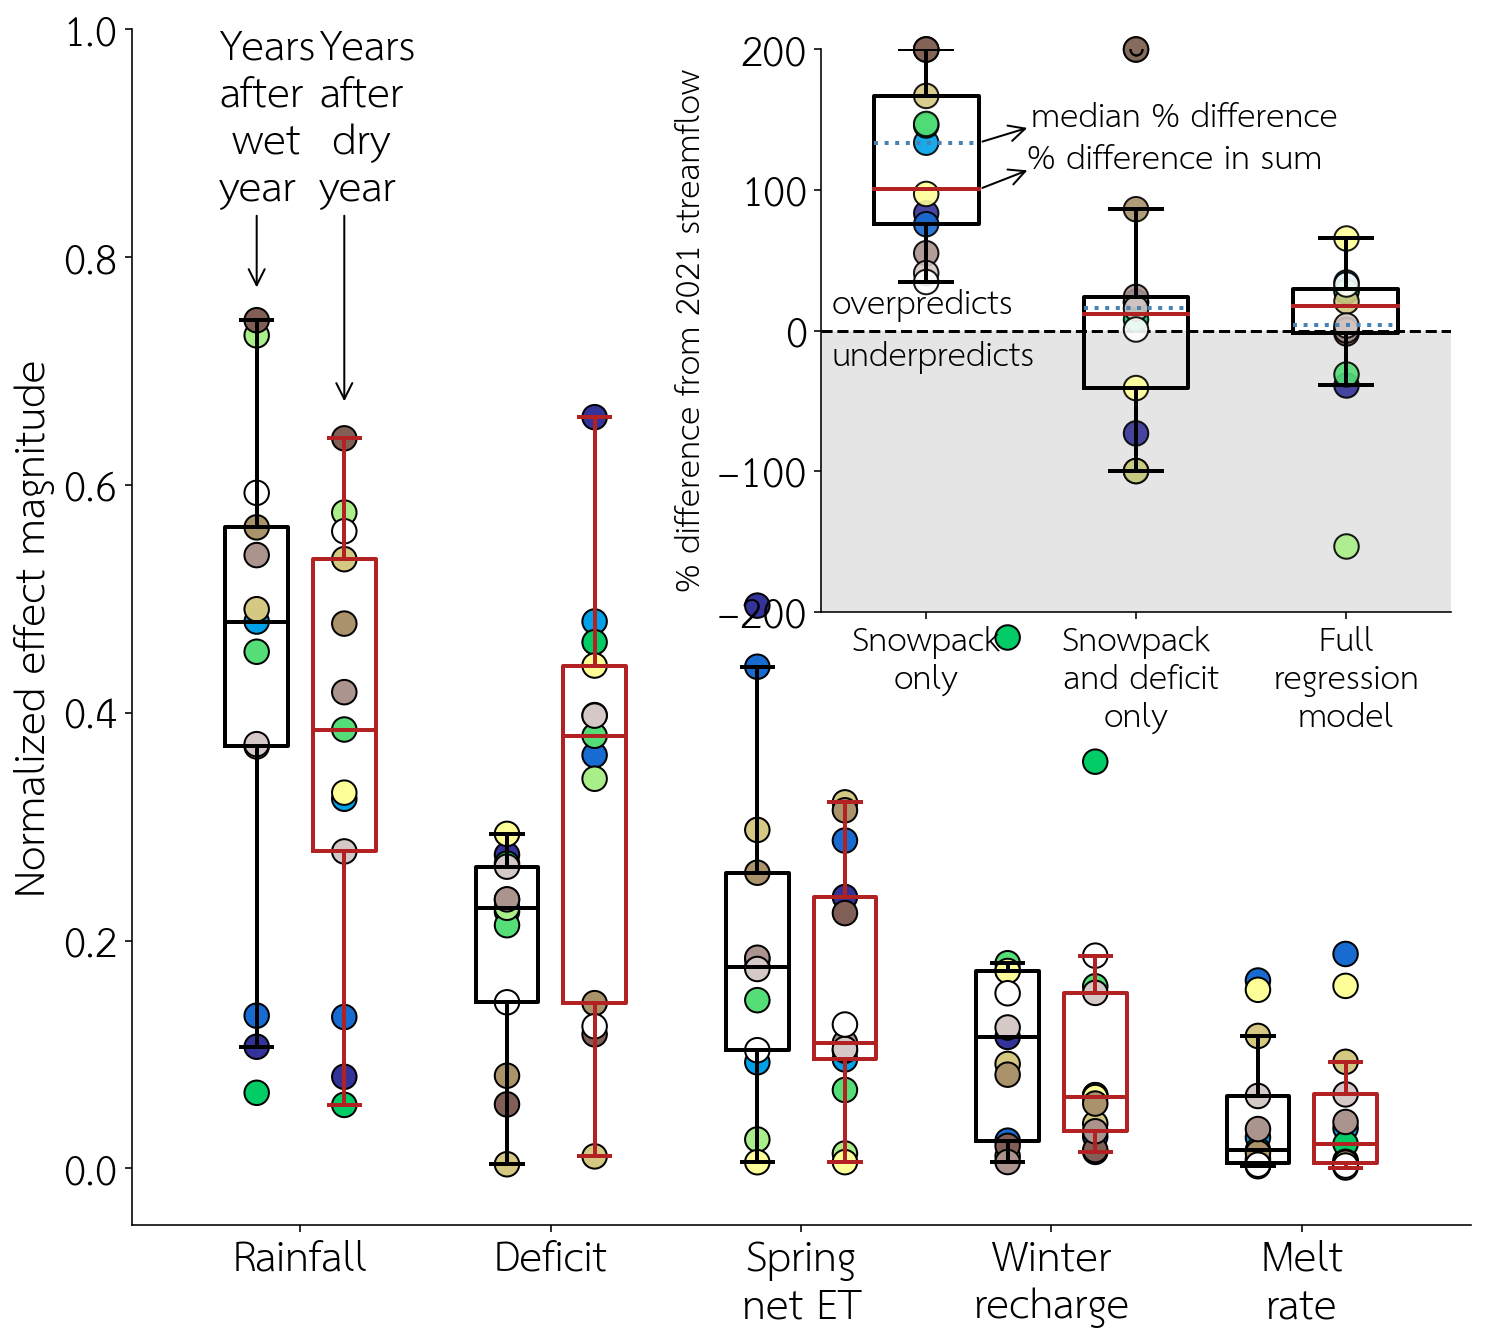

In [ ]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
plt.rcParams.update({'font.size': 20})
fig,ax0 = plt.subplots(1,figsize = (12,11),sharex=True)




colors = cm.terrain(np.linspace(0, 1, 13))
cols = ['snowfrac','Oct D','netET',
            'ETw/P','mfrac']
colnames = {'Apr 1 SWE':'Snowpack',#'SWE',
            # 'const': 'Const.',
            'snowfrac': 'Rainfall',#'(spring + winter rain) /\nWY P',
            'Oct D': 'Deficit',#'Oct. 1 D /\nWY P',
            'netET': 'Spring\nnet ET',#\n(accounting for\nspring rain)',#(spring ET - rain) /\nWY P',
            'ETw/P': 'Winter\nrecharge',#'(winter ET - rain) /\nWY P',
            'mfrac': 'Melt\nrate',#'melt rate /\n(spring ET - rain)'
            }
ticknames = [colnames[c] for c in cols]
size = 150

ax = ax0
d1 = df[[
         'snowfrac',
          'Oct D',
          'netET',
          'ETw/P',
          'mfrac',]]

rowsums = d1.abs().sum(axis=1)
for c in d1.columns:
  d1[c] = d1[c]/rowsums
print(d1.abs().median())
d1['site'] = df.site
d1 = d1.set_index('site').sort_index().reset_index()

for i in range(len(cols)):
  col = cols[i]
  ax.scatter([i]*len(d1),
             d1[col].abs().values.flatten(),
             c=colors,
             s = size,
             edgecolor = 'k')
  ax.boxplot(d1[col].abs().values.flatten(),
             positions=[i],widths = 0.25,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='black'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)

ax.set_xticks(list(range(i+1)))
ax.set_xticklabels(ticknames)#,rotation = 45)
ax.set_ylabel('Normalized effect magnitude')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_title('Wet years')
# ax.set_ylim(-10,100)


ax = ax0
d1 = df_dry[[
         'snowfrac',
          'Oct D',
          'netET',
          'ETw/P',
          'mfrac',]]

rowsums = d1.abs().sum(axis=1)
for c in d1.columns:
  d1[c] = d1[c]/rowsums
print(d1.abs().median())
d1['site'] = df.site
d1 = d1.set_index('site').sort_index().reset_index()

for i in range(len(cols)):
  col = cols[i]
  ax.scatter([i+0.35]*len(d1),
             d1[col].abs().values.flatten(),
             c=colors,
             s = size,
             edgecolor = 'k')
  ax.boxplot(d1[col].abs().values.flatten(),
             positions=[i+0.35],widths = 0.25,
           boxprops= dict(linewidth=2.0, color='firebrick'),
           whiskerprops = dict(linewidth=2.0, color='firebrick'),
           medianprops = dict(linewidth=2.0, color='firebrick'),
           capprops = dict(linewidth=2.0, color='firebrick'),
           showfliers=False)

ax.set_xticks([p+.175 for p in list(range(i+1))])
ax.set_xticklabels(ticknames)#,rotation = 45)
ax.set_ylabel('Normalized effect magnitude')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_title('Dry Years')
# ax.set_ylim(-10,100)
ax.text(-.15,.85,'Years\nafter\n wet\nyear')
ax.text(.25,.85,'Years\nafter\n dry\nyear')
ax.annotate("", xy=(0,.77), xytext=(0,.84),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(.35,.67), xytext=(.35,.84),
            arrowprops=dict(arrowstyle="->"))
ax.set_ylim(-.05,1)


ax = inset_axes(ax0, width="47%", height="47%", loc=1)
fs = 16
df= pd.DataFrame.from_dict(results1)
diff = (df.pred2021-df.Q2021)/df.Q2021
# diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[2],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)
for i in range(len(diff)):
  ax.scatter([2],[diff[i]*100],
           s = size,edgecolor = 'k',c=colors[i],
          #  marker = '*',
           alpha=0.9,clip_on=False,#label='Best model',
           label = df.site.values[i])
medval = np.nanmedian(diff)*100
sumval = np.nansum(df.pred2021-df.Q2021)/np.nansum(df.Q2021)*100
# ax.axhline(sumval,c='skyblue',lw=2)
med_diffs = [medval]
sum_diffs = [sumval]

diff_from = np.where(df.pred2021_SWE_D<0,0,df.pred2021_SWE_D)
diff = (diff_from-df.Q2021)/df.Q2021
diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[1],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'))
ax.scatter([1]*len(diff),diff*100
           ,s = size,edgecolor = 'k',c=colors,clip_on=False,
          #  label = 'SWE and D/winter P only',
           label = None,
           alpha=0.9)
medval = np.nanmedian(np.array(diff))*100
sumval= np.nansum(df.pred2021_SWE_D-df.Q2021)/np.nansum(df.Q2021)*100
# ax.axhline(sumval,c='firebrick',lw=2)
med_diffs.append(medval)
sum_diffs.append(sumval)

diff = (df.pred2021_SWE-df.Q2021)/df.Q2021
diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[0],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)
ax.scatter([0]*len(diff),diff*100
           ,s=size,edgecolor = 'k',c=colors,clip_on=False,
          #  label = 'SWE only',
           label = None,
          #  marker = 's',
           alpha=0.9)
medval = np.nanmedian(diff*100)
sumval = np.nansum(df.pred2021_SWE-df.Q2021)/np.nansum(df.Q2021)*100
# ax.axhline(sumval,c='goldenrod',lw=2)
med_diffs.append(medval)
sum_diffs.append(sumval)

ax.set_xticks([0,1,2])
ax.set_xticklabels(['Snowpack\nonly',
                    'Snowpack\n and deficit\nonly',
                    'Full\nregression\nmodel'],
                    # ['SWE only',
                    # 'SWE and\nD/winter P\nonly',
                    # 'Full\nregression\nmodel',
                    # ],
                   rotation = 0,fontsize = fs)
# ax.legend(loc='lower right',bbox_to_anchor=(1.5,-.5))
ax.set_ylim(-200,200)
ax.axhline(0,c='k',ls='--',zorder = -1)
# ax.set_xlabel('Actual 2021 spring streamflow (mm)')
ax.set_ylabel('% difference from 2021 streamflow',fontsize = fs)
ax.axhspan(-300,0,facecolor = 'k',alpha=0.1,zorder=-1)
ax.text(-.45,12
        ,'overpredicts',fontsize = fs)
ax.text(-.45,-25,'underpredicts', fontsize = fs)



ax.annotate("", xy=(.25,sum_diffs[2]), xytext=(.5,115),
            arrowprops=dict(arrowstyle="<-"))
ax.text(.48,115,'% difference in sum',fontsize = fs)
ax.annotate('', xy=(.25,med_diffs[2]), xytext=(.5,145),
            arrowprops=dict(arrowstyle="<-"))
ax.text(.5,145,"median % difference",fontsize = fs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

a = [2,1,0]
for i in range(3):
  ax.plot([a[i]-.25,a[i]+.25],[sum_diffs[i]]*2,
        c='firebrick',lw=2)
  
# ax0.text(-.5,0.78,'a)')
# ax1.text(-.5,208,'b)')
plt.savefig('regression_results.png',format='png',dpi=300,bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

snowfrac    0.480177
Oct D       0.228870
netET       0.177180
ETw/P       0.115484
mfrac       0.016187
dtype: float64
snowfrac    0.385386
Oct D       0.379905
netET       0.110337
ETw/P       0.062675
mfrac       0.021546
dtype: float64


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

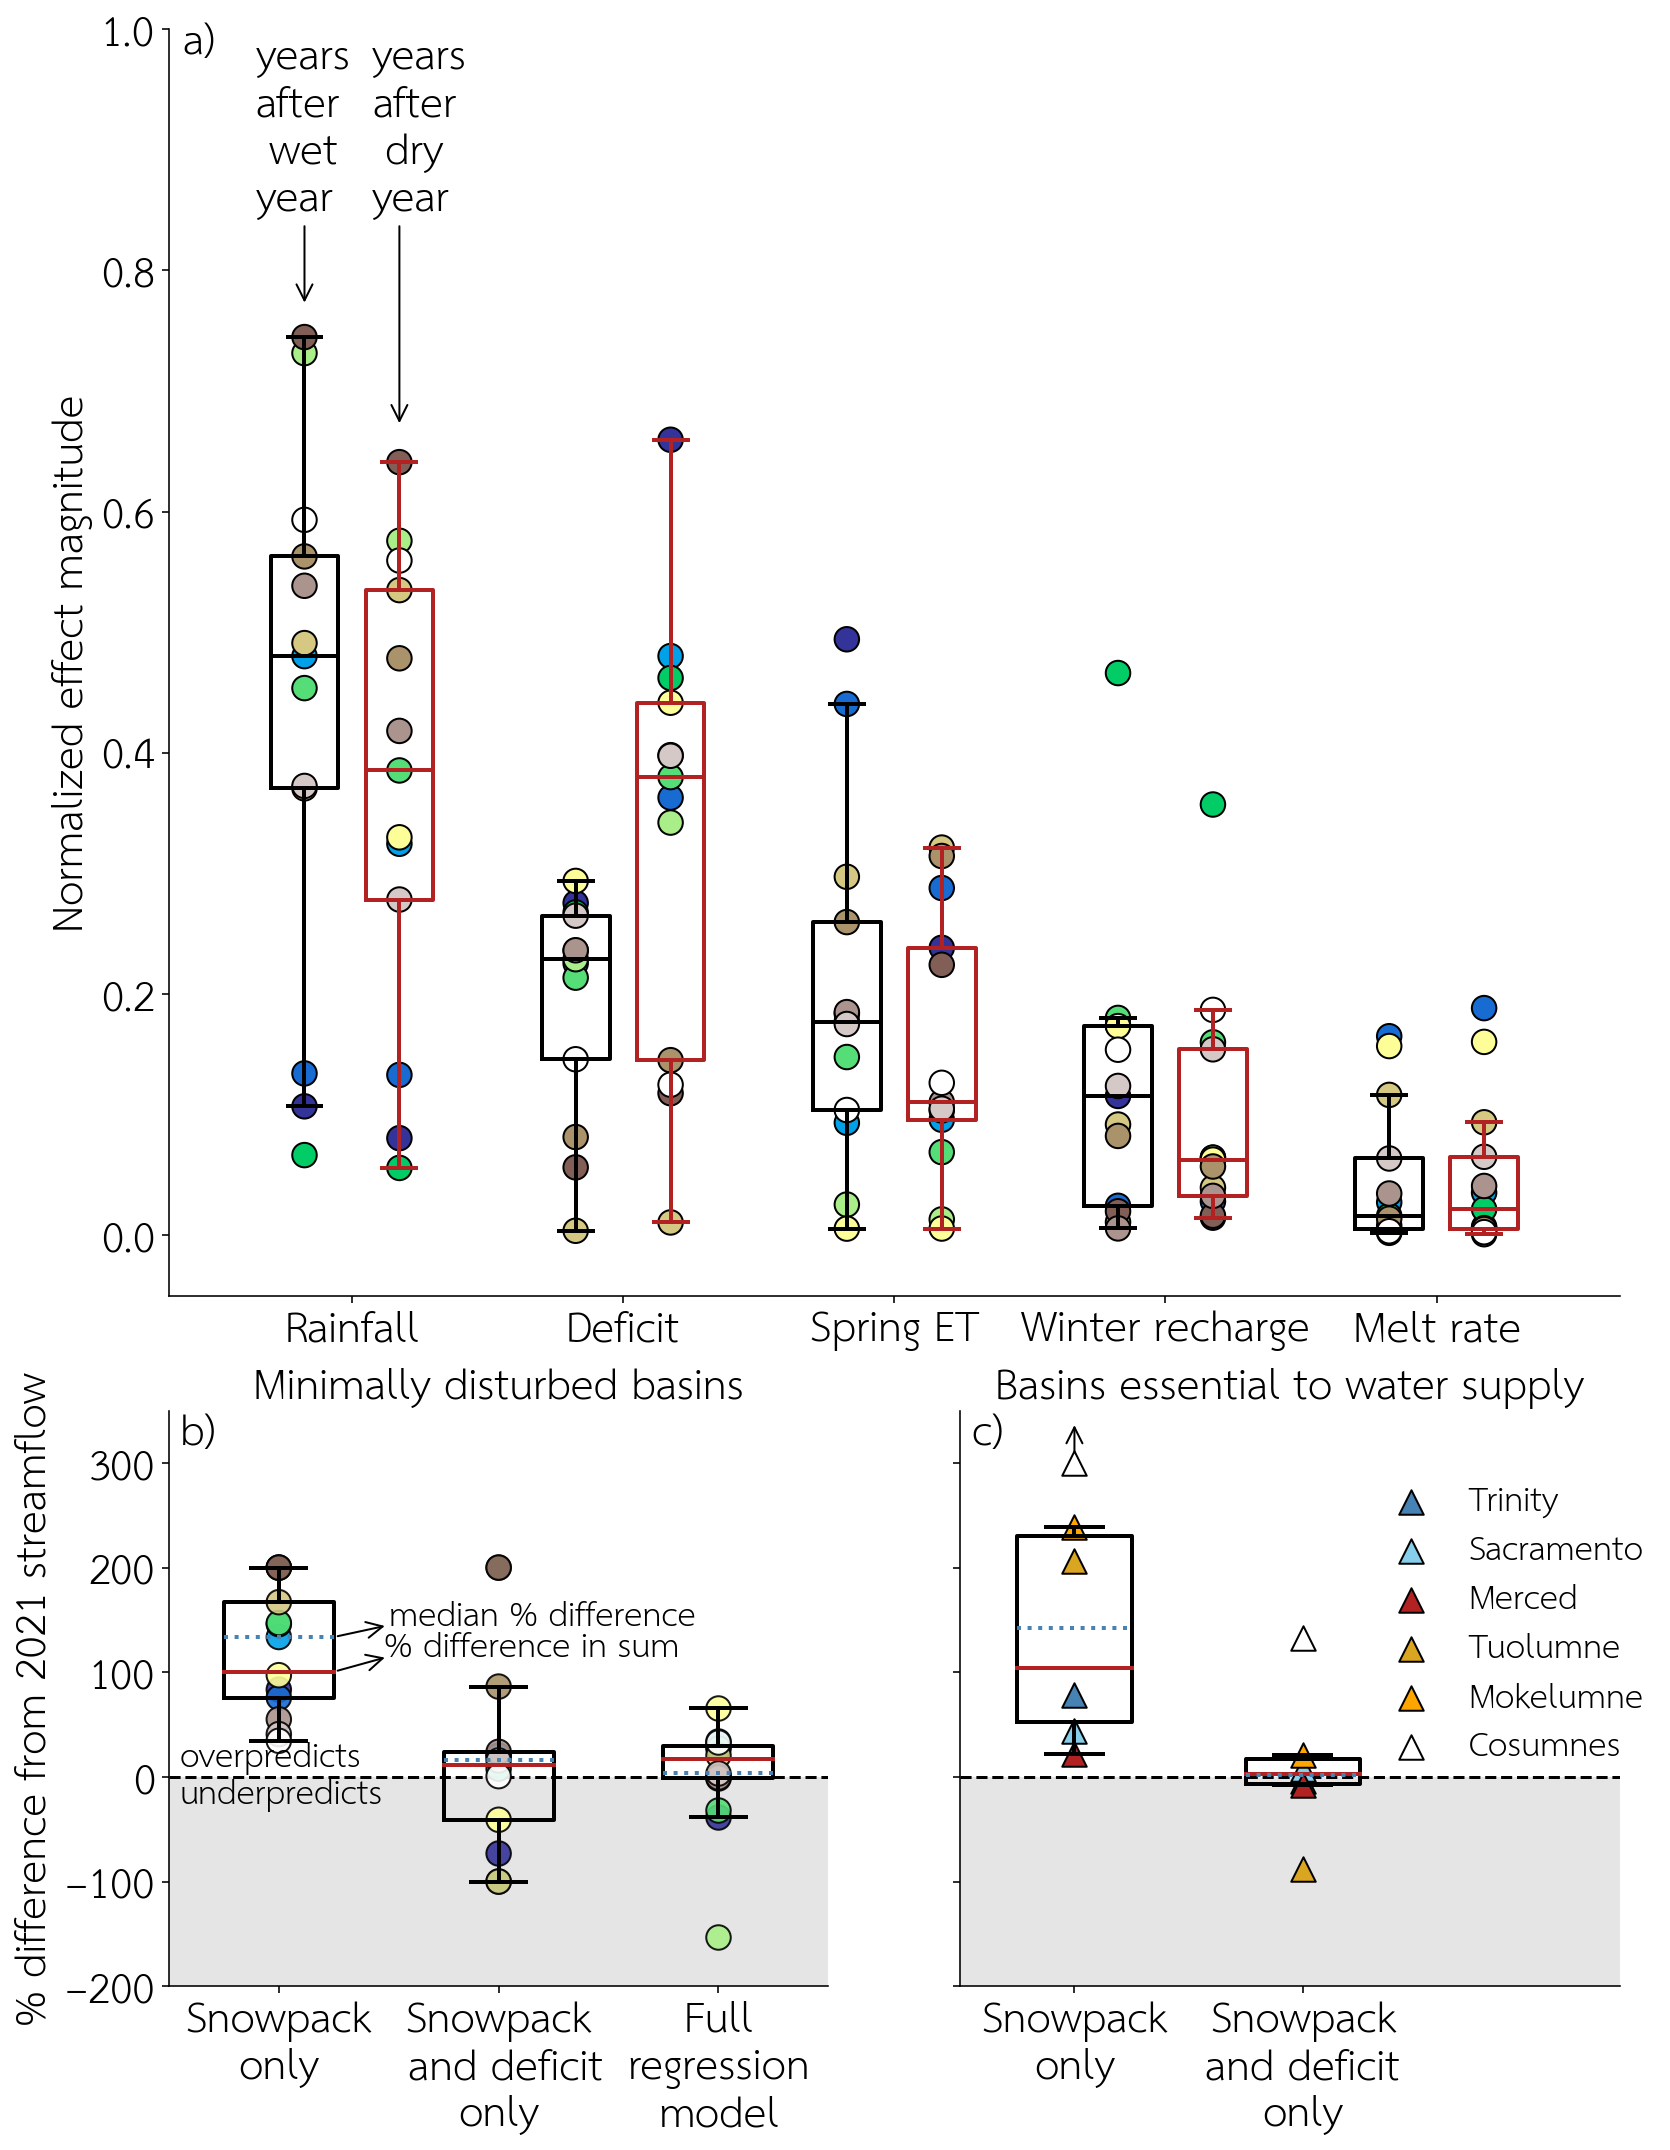

In [ ]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
plt.rcParams.update({'font.size': 20})
# fig,ax0 = plt.subplots(1,figsize = (12,11),sharex=True)
fig = plt.figure(figsize = (13,18))

gs = gridspec.GridSpec(3, 2, figure=fig)
ax0 = fig.add_subplot(gs[:2,:])
ax1 = fig.add_subplot(gs[2,0])
ax2 = fig.add_subplot(gs[2,1])


colors = cm.terrain(np.linspace(0, 1, 13))
cols = ['snowfrac','Oct D','netET',
            'ETw/P','mfrac']
colnames = {'Apr 1 SWE':'Snowpack',#'SWE',
            # 'const': 'Const.',
            'snowfrac': 'Rainfall',#'(spring + winter rain) /\nWY P',
            'Oct D': 'Deficit',#'Oct. 1 D /\nWY P',
            'netET': 'Spring ET',#\n(accounting for\nspring rain)',#(spring ET - rain) /\nWY P',
            'ETw/P': 'Winter recharge',#'(winter ET - rain) /\nWY P',
            'mfrac': 'Melt rate',#'melt rate /\n(spring ET - rain)'
            }
ticknames = [colnames[c] for c in cols]
size = 150

ax = ax0
d1 = df[[
         'snowfrac',
          'Oct D',
          'netET',
          'ETw/P',
          'mfrac',]]

rowsums = d1.abs().sum(axis=1)
for c in d1.columns:
  d1[c] = d1[c]/rowsums
print(d1.abs().median())
d1['site'] = df.site
d1 = d1.set_index('site').sort_index().reset_index()

for i in range(len(cols)):
  col = cols[i]
  ax.scatter([i]*len(d1),
             d1[col].abs().values.flatten(),
             c=colors,
             s = size,
             edgecolor = 'k')
  ax.boxplot(d1[col].abs().values.flatten(),
             positions=[i],widths = 0.25,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='black'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)

ax.set_xticks(list(range(i+1)))
ax.set_xticklabels(ticknames)#,rotation = 45)
ax.set_ylabel('Normalized effect magnitude')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_title('Wet years')
# ax.set_ylim(-10,100)


ax = ax0
d1 = df_dry[[
         'snowfrac',
          'Oct D',
          'netET',
          'ETw/P',
          'mfrac',]]

rowsums = d1.abs().sum(axis=1)
for c in d1.columns:
  d1[c] = d1[c]/rowsums
print(d1.abs().median())
d1['site'] = df.site
d1 = d1.set_index('site').sort_index().reset_index()

for i in range(len(cols)):
  col = cols[i]
  ax.scatter([i+0.35]*len(d1),
             d1[col].abs().values.flatten(),
             c=colors,
             s = size,
             edgecolor = 'k')
  ax.boxplot(d1[col].abs().values.flatten(),
             positions=[i+0.35],widths = 0.25,
           boxprops= dict(linewidth=2.0, color='firebrick'),
           whiskerprops = dict(linewidth=2.0, color='firebrick'),
           medianprops = dict(linewidth=2.0, color='firebrick'),
           capprops = dict(linewidth=2.0, color='firebrick'),
           showfliers=False)

ax.set_xticks([p+.175 for p in list(range(i+1))])
ax.set_xticklabels(ticknames)#,rotation = 45)
ax.set_ylabel('Normalized effect magnitude')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_title('Dry Years')
# ax.set_ylim(-10,100)
ax.text(-.18,.85,'years\nafter\n wet\nyear')
ax.text(.25,.85,'years\nafter\n dry\nyear')
ax.annotate("", xy=(0,.77), xytext=(0,.84),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(.35,.67), xytext=(.35,.84),
            arrowprops=dict(arrowstyle="->"))
ax.set_ylim(-.05,1)


ax = ax1#inset_axes(ax0, width="47%", height="47%", loc=1)

fs = 16
df= pd.DataFrame.from_dict(results1)
diff = (df.pred2021-df.Q2021)/df.Q2021
# diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[2],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)
for i in range(len(diff)):
  ax.scatter([2],[diff[i]*100],
           s = size,edgecolor = 'k',c=colors[i],
          #  marker = '*',
           alpha=0.9,clip_on=False,#label='Best model',
           label = df.site.values[i])
medval = np.nanmedian(diff)*100
sumval = np.nansum(df.pred2021-df.Q2021)/np.nansum(df.Q2021)*100
# ax.axhline(sumval,c='skyblue',lw=2)
med_diffs = [medval]
sum_diffs = [sumval]

diff_from = np.where(df.pred2021_SWE_D<0,0,df.pred2021_SWE_D)
diff = (diff_from-df.Q2021)/df.Q2021
diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[1],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)
ax.scatter([1]*len(diff),diff*100
           ,s = size,edgecolor = 'k',c=colors,clip_on=False,
          #  label = 'SWE and D/winter P only',
           label = None,
           alpha=0.9)
medval = np.nanmedian(np.array(diff))*100
sumval= np.nansum(df.pred2021_SWE_D-df.Q2021)/np.nansum(df.Q2021)*100
# ax.axhline(sumval,c='firebrick',lw=2)
med_diffs.append(medval)
sum_diffs.append(sumval)

diff = (df.pred2021_SWE-df.Q2021)/df.Q2021
diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[0],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)
ax.scatter([0]*len(diff),diff*100
           ,s=size,edgecolor = 'k',c=colors,clip_on=False,
          #  label = 'SWE only',
           label = None,
          #  marker = 's',
           alpha=0.9)
medval = np.nanmedian(diff*100)
sumval = np.nansum(df.pred2021_SWE-df.Q2021)/np.nansum(df.Q2021)*100
# ax.axhline(sumval,c='goldenrod',lw=2)
med_diffs.append(medval)
sum_diffs.append(sumval)

ax.set_xticks([0,1,2])
ax.set_xticklabels(['Snowpack\nonly',
                    'Snowpack\n and deficit\nonly',
                    'Full\nregression\nmodel'],
                    # ['SWE only',
                    # 'SWE and\nD/winter P\nonly',
                    # 'Full\nregression\nmodel',
                    # ],
                   rotation = 0,)
# ax.legend(loc='lower right',bbox_to_anchor=(1.5,-.5))

# ax.set_xlabel('Actual 2021 spring streamflow (mm)')
ax.set_ylabel('% difference from 2021 streamflow')#nat minimally disturbed sites',)




ax.annotate("", xy=(.25,sum_diffs[2]), xytext=(.5,115),
            arrowprops=dict(arrowstyle="<-"))
ax.text(.48,115,'% difference in sum',fontsize = fs)
ax.annotate('', xy=(.25,med_diffs[2]), xytext=(.5,145),
            arrowprops=dict(arrowstyle="<-"))
ax.text(.5,145,"median % difference",fontsize = fs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xticklabels(['','',''])

a = [2,1,0]
for i in range(3):
  ax.plot([a[i]-.25,a[i]+.25],[sum_diffs[i]]*2,
        c='firebrick',lw=2)
  
ax = ax2

swe_err = [78.24449097536808,
 43.524074950131265,
 21.92131988155504,
 206.14597851817337,
 238.37555245842492,
 832.3694059775669]
swed_err = [-3.8203186490566114,
 7.586284419553596,
 -8.064829350155858,
 -87.88957421554134,
 20.650843314480795,
 133.03785741461883]

colors = ['steelblue','skyblue','firebrick','goldenrod',
          'orange','white']
sitenames = ['Trinity',
       'Sacramento',
       'Merced',
       'Tuolumne',
       'Mokelumne',
       'Cosumnes']

for i in range(len(swed_err)):
  ax.scatter([0],swe_err[i],s=size,
           edgecolor = 'k',c=colors[i],label=sitenames[i],marker = '^')
ax.boxplot(swe_err,positions=[0],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)
ax.scatter([0],[300],s=size,edgecolor = 'k',c=colors[i],label=None,
           clip_on=False,marker = '^')
ax.annotate('',xy = (0,300),
            xytext = (0,340),
            arrowprops = dict(arrowstyle="<-",
                            connectionstyle="arc3"),
            clip_on=False, zorder = -1
            )

for i in range(len(swed_err)):
  ax.scatter([1],swed_err[i],s=size,
           edgecolor = 'k',c=colors[i],label=None,marker = '^')
ax.boxplot(swed_err,positions=[1],widths=0.5,
          boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='steelblue',ls=':'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)

# ax.set_ylim(-300,300)
# ax.set_xticks([0,1,2])
ax.set_xticklabels(['Snowpack\nonly','Snowpack\nand deficit\nonly',])
# ax.set_ylabel('% error in 2021 streamflow\nat 6 basins important to water supply',)

ax.legend(loc='upper right',bbox_to_anchor = (1.08,.92),frameon=False,
          fontsize = fs)

# ax.text(-0.45,5,'overpredicts',fontsize = fs)
# ax.text(-0.45,-15,'underpredicts', fontsize = fs)
ax.plot([1.75,2.25],[100,100],c='white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels([])
ax.set_title('Basins essential to water supply',fontsize = 20)

sum_diffs = [103.7,2.6]

for i in range(2):
  ax.plot([i-.25,i+.25],[sum_diffs[i]]*2,
        c='firebrick',lw=2)

for ax in [ax1,ax2]:
  ax.axhspan(-300,0,facecolor = 'k',alpha=0.1,zorder=-1)
  ax.set_ylim(-200,350)
  ax.axhline(0,c='k',ls='--',zorder = -1)   

ax = ax1
ax.text(-.45,10
        ,'overpredicts',fontsize = fs)
ax.text(-.45,-25,'underpredicts', fontsize = fs)
ax.set_title('Minimally disturbed basins',fontsize = 20)


ax0.text(-.45,0.98,'a)')
ax1.text(-.45,318,'b)')
ax2.text(-.45,318,'c)')
plt.savefig('regression_results_all.png',format='png',dpi=300,bbox_inches='tight')

In [ ]:
# print out percent errors for (best, SWE and D/wintP, SWE)
med_diffs, sum_diffs

([3.9831564929178844, 15.697190501060721, 133.64522688372543],
 [17.315542455358017, 11.597267827236179, 100.46669312740002])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

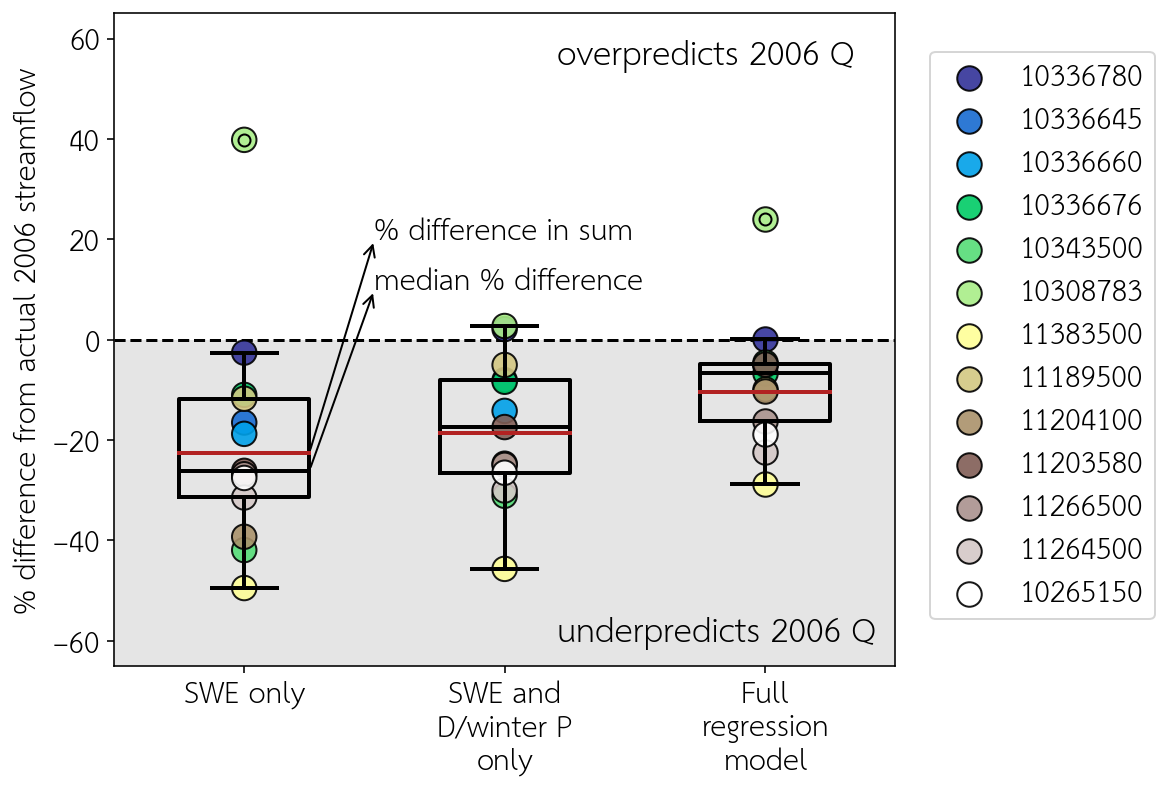

In [ ]:
import matplotlib.cm as cm
# plot overall change in error across all sites with different models
# in this version, 'best' is the regression model with all parameters included
df= pd.DataFrame.from_dict(results1)
%matplotlib inline
plt.rcParams.update({'font.size': 14})
fig,axs = plt.subplots(1,figsize = (7,6))

size = 150
bins = np.linspace(-200,200,400)
colors = cm.terrain(np.linspace(0, 1, 13))

ax = axs
diff = (df.pred2006-df.Q2006)/df.Q2006
# diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[2],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='black'),
           capprops = dict(linewidth=2.0, color='black'))
for i in range(len(diff)):
  ax.scatter([2],[diff[i]*100],
           s = size,edgecolor = 'k',c=colors[i],
          #  marker = '*',
           alpha=0.9,clip_on=False,#label='Best model',
           label = df.site.values[i])
medval = np.nanmedian(diff)*100
sumval = np.nansum(df.pred2006-df.Q2006)/np.nansum(df.Q2006)*100
# ax.axhline(sumval,c='skyblue',lw=2)
med_diffs = [medval]
sum_diffs = [sumval]

diff_from = np.where(df.pred2006_SWE_D<0,0,df.pred2006_SWE_D)
diff = (diff_from-df.Q2006)/df.Q2006
diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[1],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='black'),
           capprops = dict(linewidth=2.0, color='black'))
ax.scatter([1]*len(diff),diff*100
           ,s = size,edgecolor = 'k',c=colors,clip_on=False,
          #  label = 'SWE and D/winter P only',
           label = None,
           alpha=0.9)
medval = np.nanmedian(np.array(diff))*100
sumval= np.nansum(df.pred2006_SWE_D-df.Q2006)/np.nansum(df.Q2006)*100
# ax.axhline(sumval,c='firebrick',lw=2)
med_diffs.append(medval)
sum_diffs.append(sumval)

diff = (df.pred2006_SWE-df.Q2006)/df.Q2006
diff = np.where(diff>2.,2.,diff)
ax.boxplot(diff*100,positions=[0],widths = 0.5,
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='black'),
           capprops = dict(linewidth=2.0, color='black'))
ax.scatter([0]*len(diff),diff*100
           ,s=size,edgecolor = 'k',c=colors,clip_on=False,
          #  label = 'SWE only',
           label = None,
          #  marker = 's',
           alpha=0.9)
medval = np.nanmedian(diff*100)
sumval = np.nansum(df.pred2006_SWE-df.Q2006)/np.nansum(df.Q2006)*100
# ax.axhline(sumval,c='goldenrod',lw=2)
med_diffs.append(medval)
sum_diffs.append(sumval)


ax = axs
ax.set_xticks([0,1,2])
ax.set_xticklabels(['SWE only',
                    'SWE and\nD/winter P\nonly',
                    'Full\nregression\nmodel',
                    ],
                   rotation = 0)
ax.legend(loc='lower right',bbox_to_anchor=(1.35,0.05))
ax.set_ylim(-65,65)
ax.axhline(0,c='k',ls='--',zorder = -1)
# ax.set_xlabel('Actual 2021 spring streamflow (mm)')
ax.set_ylabel('% difference from actual 2006 streamflow')
ax.axhspan(-300,0,facecolor = 'k',alpha=0.1,zorder=-1)
ax.text(1.2,55,'overpredicts 2006 Q',fontsize = 16)
ax.text(1.2,-60,'underpredicts 2006 Q', fontsize = 16)

ax.annotate("", xy=(.25,sum_diffs[2]), xytext=(.5,20),
            arrowprops=dict(arrowstyle="<-"))
ax.text(.5,20,'% difference in sum')
ax.annotate('', xy=(.25,med_diffs[2]), xytext=(.5,10),
            arrowprops=dict(arrowstyle="<-"))
ax.text(.5,10,"median % difference")

a = [2,1,0]
for i in range(3):
  ax.plot([a[i]-.25,a[i]+.25],[sum_diffs[i]]*2,
        c='firebrick',lw=2)

plt.savefig('regression_performance2006_histo.pdf',format='pdf',bbox_inches='tight')


In [ ]:
sum_diffs,med_diffs

([-10.521862624066852, -18.624553782420193, -22.567371430189276],
 [-6.702652546092769, -17.42106691616236, -26.149284535937824])